# Analysis of data from first dataset Stage5-6s-35s

### Import Packages

In [41]:
# Import packages
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy.sparse
import os
import sys
from importlib import reload
#import pdfkit as pdf
#import bbknn
import pickle


# Add path to custom local functions
sys.path.append('/home/pourquielab/Desktop/backup/datachicken')
#sys.path.append('../scTools_190411/')
import scTools_dew as dew

In [42]:
# Load/reload custom functions
dew = reload(dew)

In [43]:
# ScanPy settings
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=120)  # low dpi (dots per inch) yields small inline figures
sc.logging.print_versions()

# Matplotlib settings
plt.rcParams['pdf.fonttype']=42  # Necessary to export text (rather than curves) in pdf files

scanpy==1.4.4 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.3 scipy==1.3.2 pandas==0.25.3 scikit-learn==0.21.3 statsmodels==0.10.2 python-igraph==0.8.2 louvain==0.6.1


### Import Libraries

_________________ 6s1
Loading from npz file
(25361, 13309) 

_________________ 6s2
Loading from npz file
(26163, 13309) 



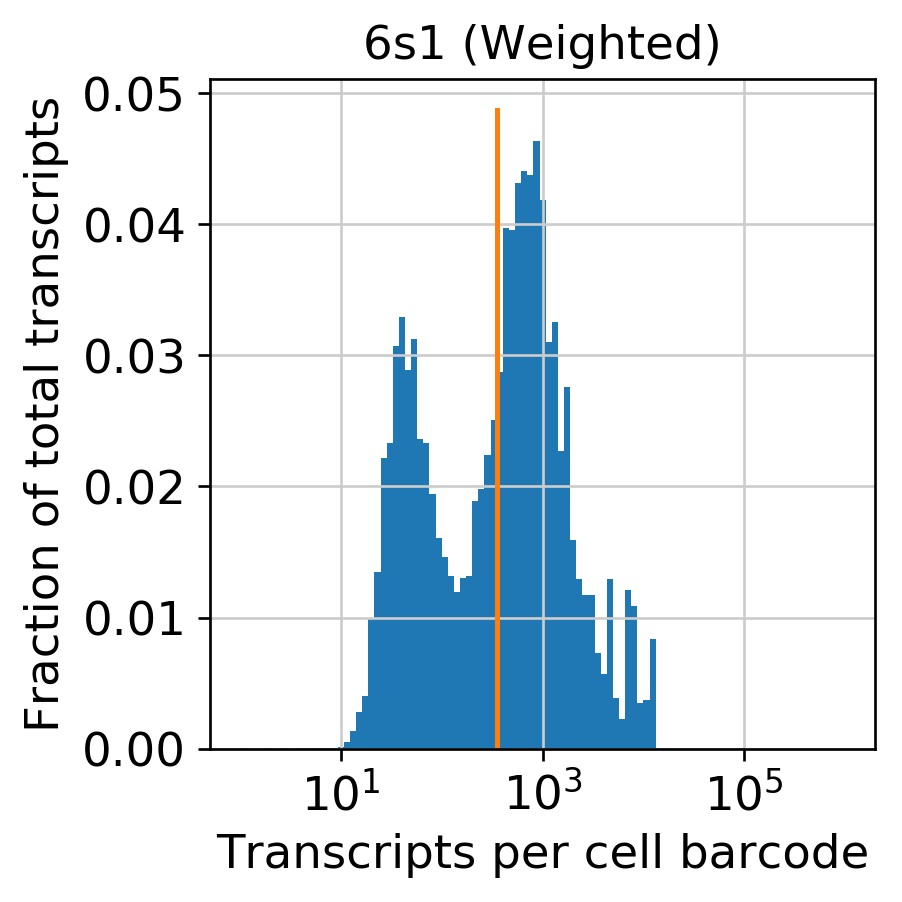

Filtering barcodes for 6s1  ( 1898 / 25361 )
filtered out 23463 cells that haveless than 350 counts


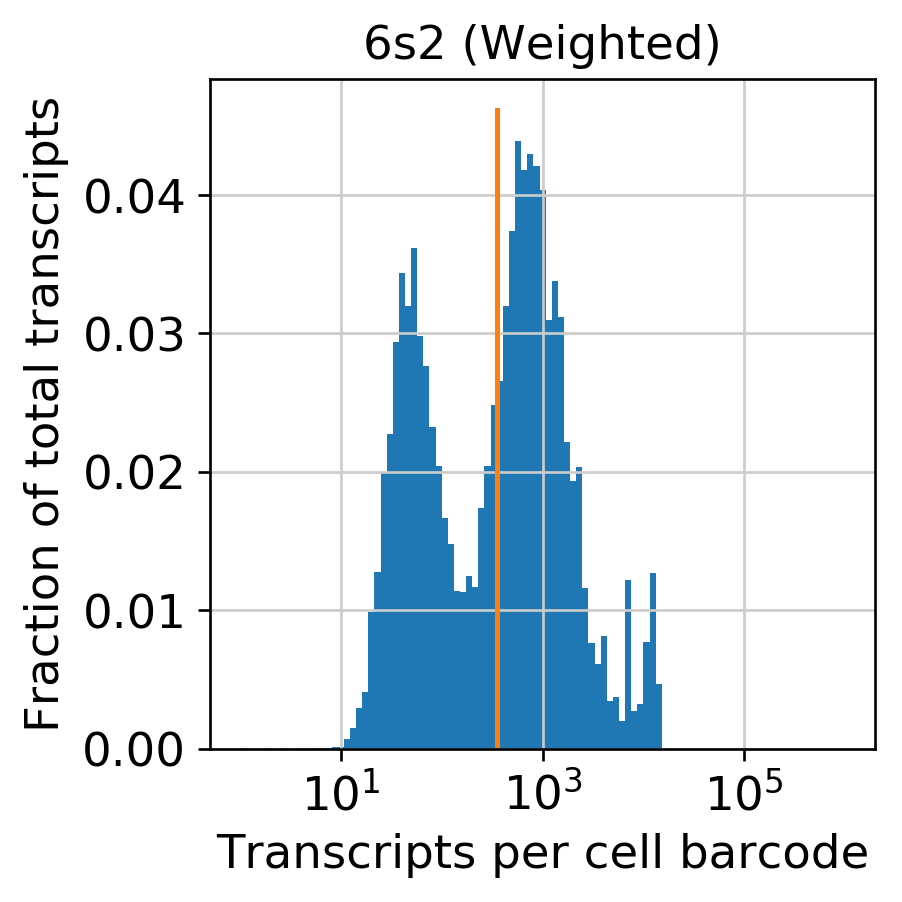

Filtering barcodes for 6s2  ( 1813 / 26163 )
filtered out 24350 cells that haveless than 350 counts

 AnnData object with n_obs × n_vars = 3711 × 13309 
    obs: 'batch', 'cell_names', 'library_id', 'n_counts', 'unique_cell_id'


In [4]:
# load libraries
#input_path = '/Users/dan/Dropbox (HMS)/Data/inDrops/OP_Oscillations/' # full path to all inDrops datasets
input_path = '/home/pourquielab/Desktop/backup/datachicken/' # full path to all inDrops datasets
libnames_mmES = ['6s1', '6s2',]
mmES = dew.load_inDrops_V3(libnames_mmES, input_path)

# set barcode abundance threshold
#mmES['st41']['adata'].uns['counts_thresh'] = 400
#mmES['st42']['adata'].uns['counts_thresh'] = 400
#mmES['st51']['adata'].uns['counts_thresh'] = 600
#mmES['st52']['adata'].uns['counts_thresh'] = 600
#mmES['3s1']['adata'].uns['counts_thresh'] = 200
#mmES['3s2']['adata'].uns['counts_thresh'] = 200
mmES['6s1']['adata'].uns['counts_thresh'] = 350
mmES['6s2']['adata'].uns['counts_thresh'] = 350
#mmES['35s1']['adata'].uns['counts_thresh'] = 700
#mmES['35s2']['adata'].uns['counts_thresh'] = 700


# perform filtering
for s in libnames_mmES:
    dew.filter_abundant_barcodes(mmES[s]['adata']) # filter and save histogram plots to file
    
# merge all libraries    
mmES = mmES['6s1']['adata'].concatenate(mmES['6s2']['adata'],)
print('\n',mmES)

### Add Library Annotations

In [5]:
# Specify timepoints and samples for each library_id
timepoint_dict = {'d3':['6s1','6s2'],}

sample_dict = {'d3':['6s1','6s2'],}
              

# Invert the dictionaries
timepoint_dict_inv = dict((v,k) for k in timepoint_dict for v in timepoint_dict[k])
sample_dict_inv = dict((v,k) for k in sample_dict for v in sample_dict[k])


# Generate per cell annotations
timepoint_id = []
sample_id = []


for s in mmES.obs['library_id']:
    timepoint_id.append(timepoint_dict_inv[s])
    sample_id.append(sample_dict_inv[s])
mmES.obs['time_id'] = timepoint_id
mmES.obs['sample_id'] = sample_id


### Save AnnData DataSet to File

### Process & Normalize

In [6]:
# Perform basic filtering
sc.pp.filter_cells(mmES, min_genes=400)
sc.pp.filter_genes(mmES, min_cells=3)

# Optional: exclude unwanted genes from filtered gene list so they 
# don't contribute to the 2-D embedding, clustering, etc.

exclude_genes = ['ND1', 'ND2', 'ND4', 'ATP6', 'CYTB', 'COII', 'COX3', 'COX1','ND5','ND3','ND6'
                ,'RPL10A','RPL12','RPL13','RPL14','RPL15','RPL17','RPL21','RPL22','RPL23','RPL27A',
                 'RPL3','RPL32','RPL36','RPL36AL','RPL38','RPL5','RPL6','RPL7A','RPL9','RPN1','RPS10',
                 'RPS11','RPS14','RPS15','RPS17','RPS19','RPS20','RPS24','RPS25','RPS26','RPS27L',
                 'RPS4X','RPS8','RPSAP58','MRPL10','MRPL16','MRPL17','MRPL18','MRPL2','MRPL24',
                 'MRPL28','MRPL3','MRPL33','MRPL35','MRPL39','MRPL40','MRPL43','MRPL54','MRPL57',
                 'MRPL58','MRPL9','MRPS11','MRPS24','MRPS25','MRPS27','MRPS31','MRPS9','RPL19',
                 'RPL22L1','RPL24','RPL30','RPL34','RPL39','RPL7','RPL7L1','RPLP0','RPLP1','RPLP2',
                 'RPS12','RPS13','RPS21','RPS24','RPS27A','RPS28','RPS3A','RPS4X','RPS6','RPS7',
                 'ITGB1BP3','RPL35A','AKT3','TWNK','MEF2A','SLC25A4']
keep_genes = [g for g in mmES.var_names if g not in exclude_genes]
mmES = mmES[:, keep_genes]

# Before doing any further processing, store a logarithmized version of the raw data
mmES.raw = sc.pp.log1p(mmES, copy=True)

# Save current n_counts as n_counts_pre_norm
mmES.obs['n_counts_pre_norm'] = mmES.obs['n_counts']

# Perform total counts normalization
sc.pp.normalize_total(mmES)

# Logarithmize the data
sc.pp.log1p(mmES)

# Identify highly variable genes
sc.pp.highly_variable_genes(mmES, n_top_genes=1000)
# Regress out n_counts and percent_mito
sc.pp.regress_out(mmES, ['n_counts_pre_norm'])
sc.pp.regress_out(mmES, ['library_id'])
# Scale the data
sc.pp.scale(mmES)


filtered out 2076 cells that haveless than 400 genes expressed
filtered out 2773 genes that are detectedin less than 3 cells
Normalizing counts per cell.
    finished (0:00:00):normalized adata.X
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
regressing out ['n_counts_pre_norm']
    sparse input is densified and may lead to high memory use


... storing 'cell_names' as categorical
... storing 'library_id' as categorical
... storing 'unique_cell_id' as categorical
... storing 'time_id' as categorical
... storing 'sample_id' as categorical


    finished (0:00:23)
regressing out ['library_id']
    finished (0:00:23)


calculating cell cycle phase
computing score 'S_score'
    finished (0:00:00)
computing score 'G2M_score'
    finished (0:00:00)
-->     'phase', cell cycle phase (adata.obs)
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 50
    finished (0:00:00)


... storing 'phase' as categorical


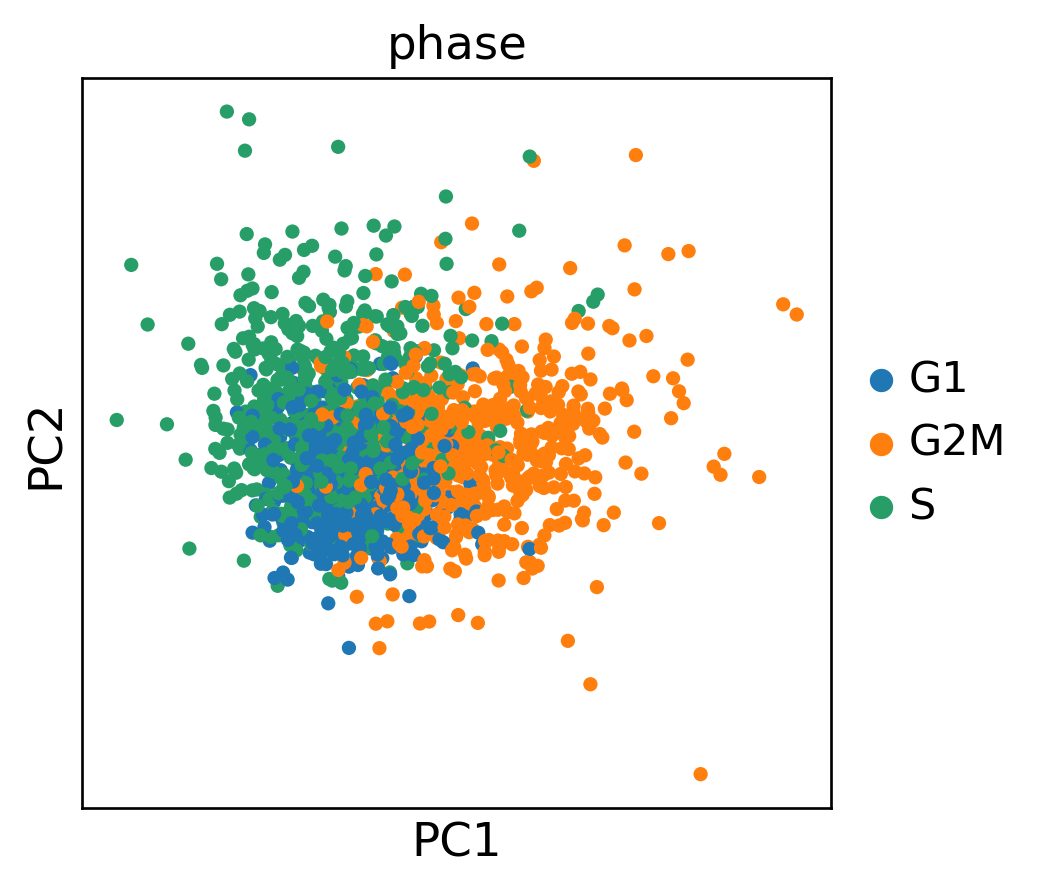

regressing out ['S_score', 'G2M_score']


... storing 'phase' as categorical


    finished (0:00:24)
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 50
    finished (0:00:00)


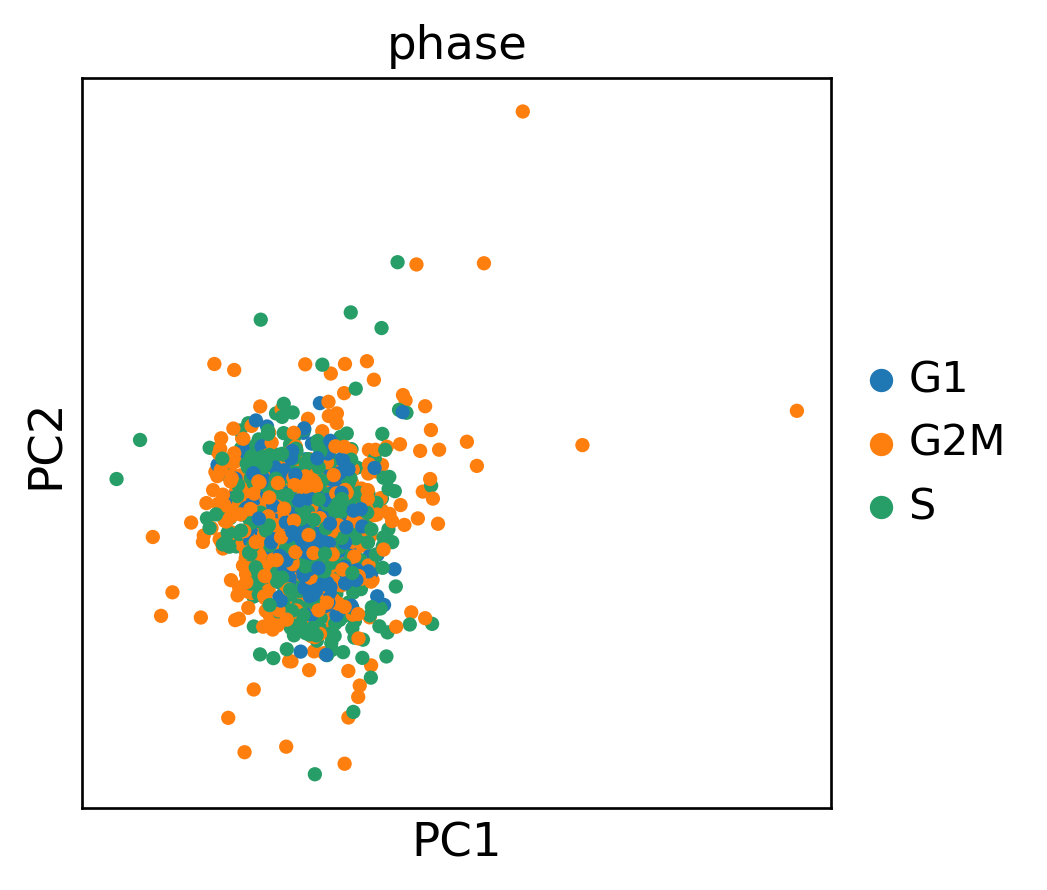

In [7]:
# Need to remove any rows/columns containing all zeros
sc.pp.filter_cells(mmES, min_genes=1)
sc.pp.filter_genes(mmES, min_cells=1)

# Import cell cycle gene list
cell_cycle_genes = [x.strip() for x in open('./regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in mmES.var_names]

# Score cell cycle
sc.tl.score_genes_cell_cycle(mmES, s_genes=s_genes, g2m_genes=g2m_genes)

# Visualize cell cycle PCA trends
mmES_cc_genes = mmES[:, cell_cycle_genes]
sc.tl.pca(mmES_cc_genes, use_highly_variable=False)
sc.pl.pca_scatter(mmES_cc_genes, color='phase')

# Regress out cell cycle
sc.pp.regress_out(mmES, ['S_score', 'G2M_score'])
sc.pp.scale(mmES)

# Visualize cell cycle PCA trends post-regression
mmES_cc_genes = mmES[:, cell_cycle_genes]
sc.tl.pca(mmES_cc_genes, use_highly_variable=False)
sc.pl.pca_scatter(mmES_cc_genes, color='phase')

In [8]:
print('\n',mmES)


 AnnData object with n_obs × n_vars = 1635 × 10443 
    obs: 'batch', 'cell_names', 'library_id', 'n_counts', 'unique_cell_id', 'time_id', 'sample_id', 'n_genes', 'n_counts_pre_norm', 'S_score', 'G2M_score', 'phase'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'


In [52]:
mmES=sc.read('datachicken-6s.h5ad')

### Compute Embeddings

In [53]:
# Perform PCA and construct a batch-balanced neighbor graph
sc.tl.pca(mmES, n_comps=50, svd_solver='arpack')
sc.pp.neighbors(mmES, n_neighbors=10, n_pcs=50, use_rep='X_pca')
#dew.export_to_graphml(mmES, filename='Gephi/mmES_bb.graphml')

# Compute sklearn-tSNE and UMAP embeddings
#sc.tl.tsne(mmES, use_fast_tsne=False, random_state=None) #previously 802 now set to 'None' to get a random tSNE embedding
#sc.tl.umap(mmES)


computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00)
computing neighbors
    finished (0:00:00)


computing UMAP
    finished (0:00:03)


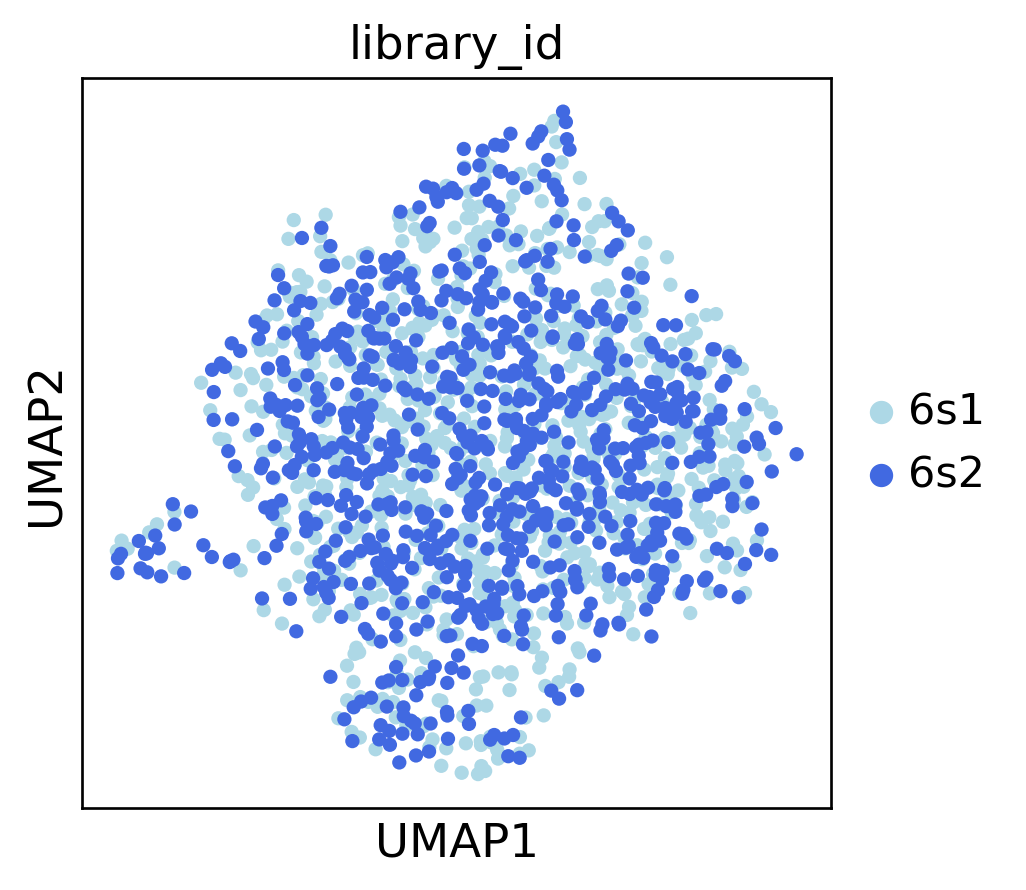

In [54]:
#Compute & plot UMAP
sc.tl.umap(mmES)
sc.pl.umap(mmES, color=['library_id'],palette=['lightblue','royalblue',])

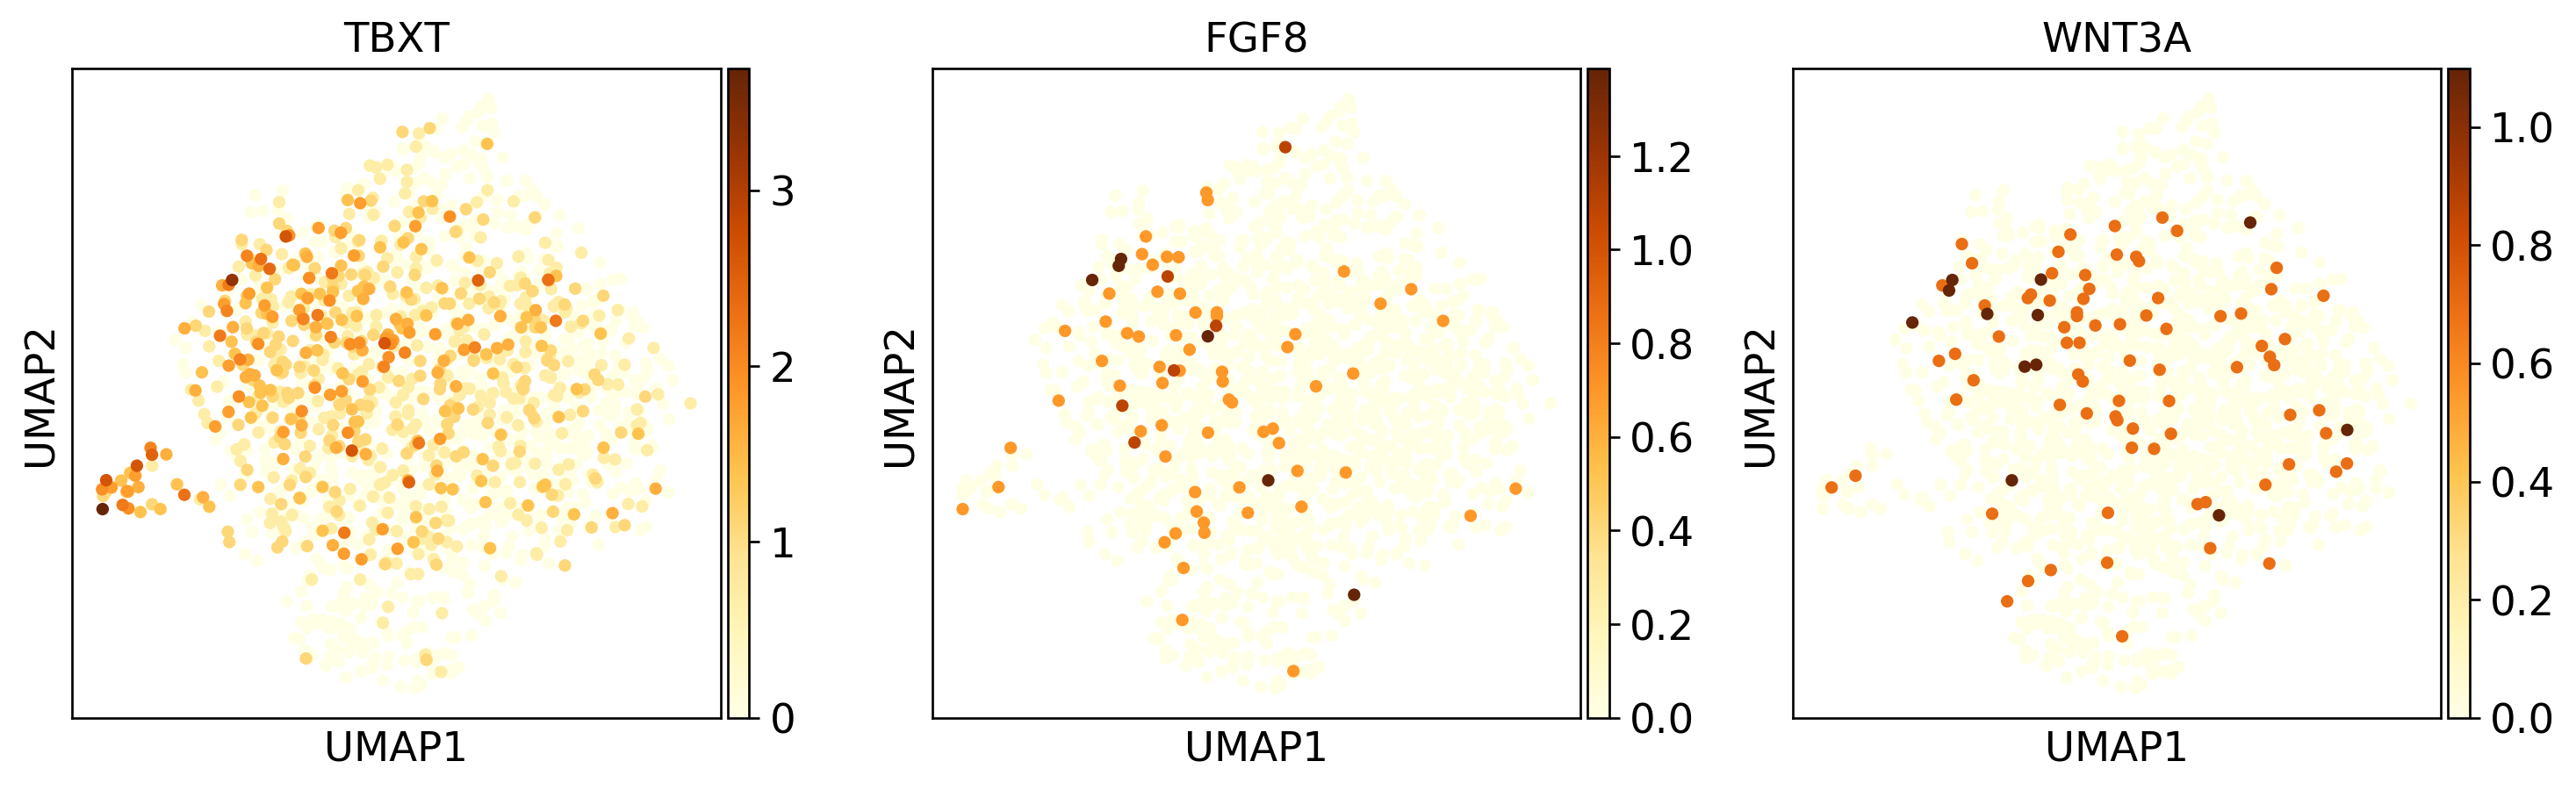

In [55]:
# Overlay genes
sc.pl.umap(mmES, color=['TBXT','FGF8','WNT3A', ], cmap='YlOrBr')

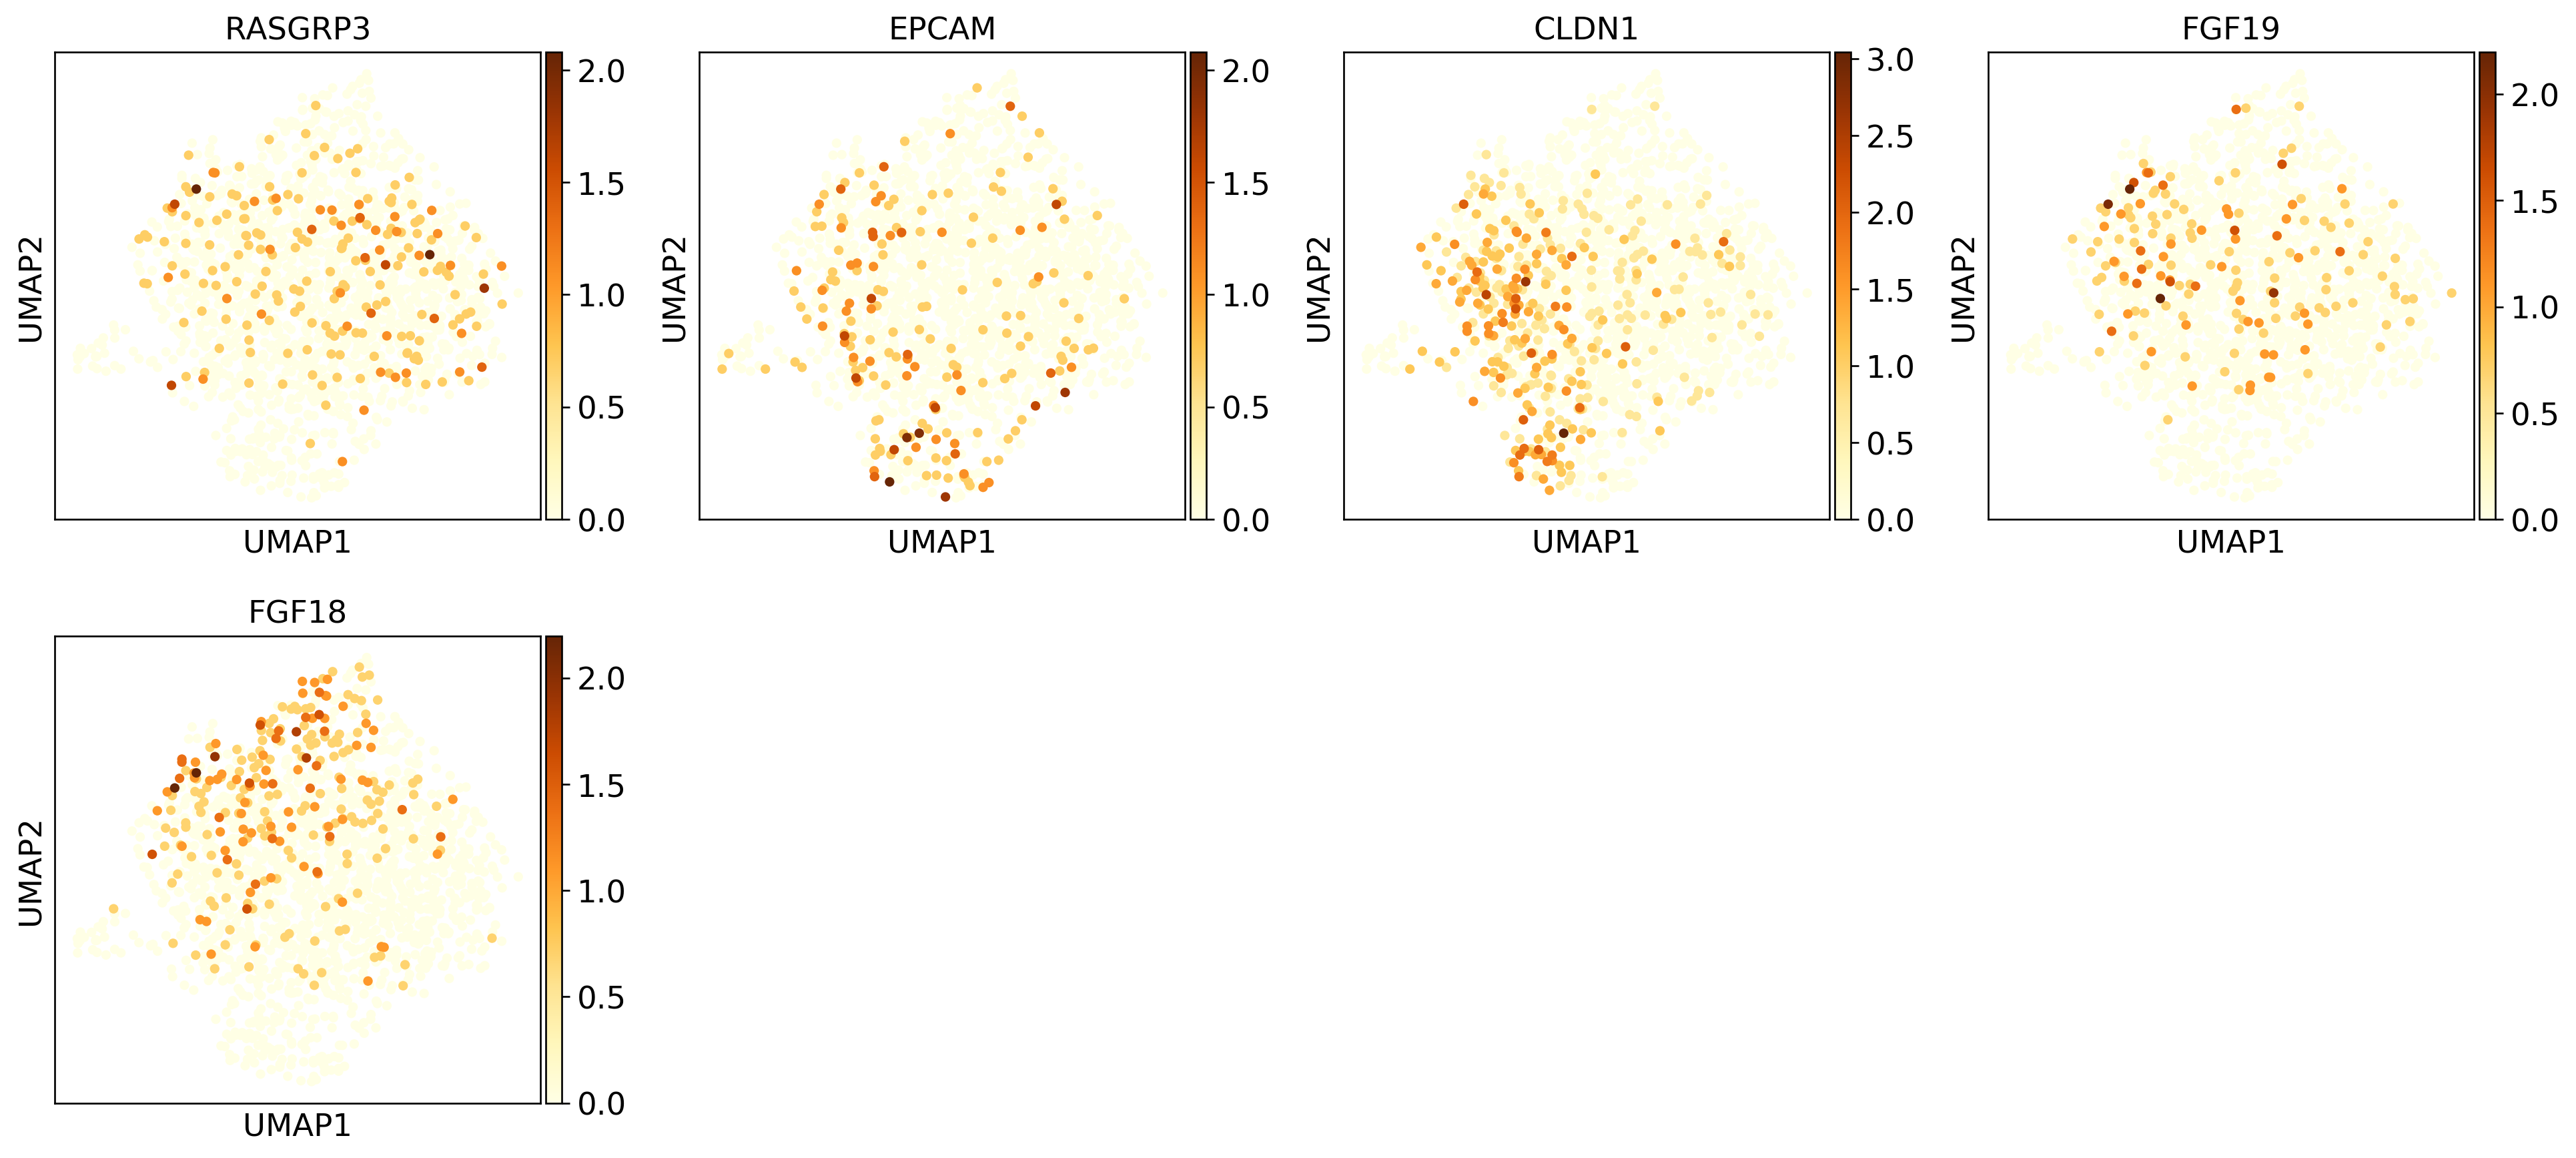

In [56]:
# Overlay genes
sc.pl.umap(mmES, color=['RASGRP3','EPCAM','CLDN1','FGF19','FGF18' ], cmap='YlOrBr')

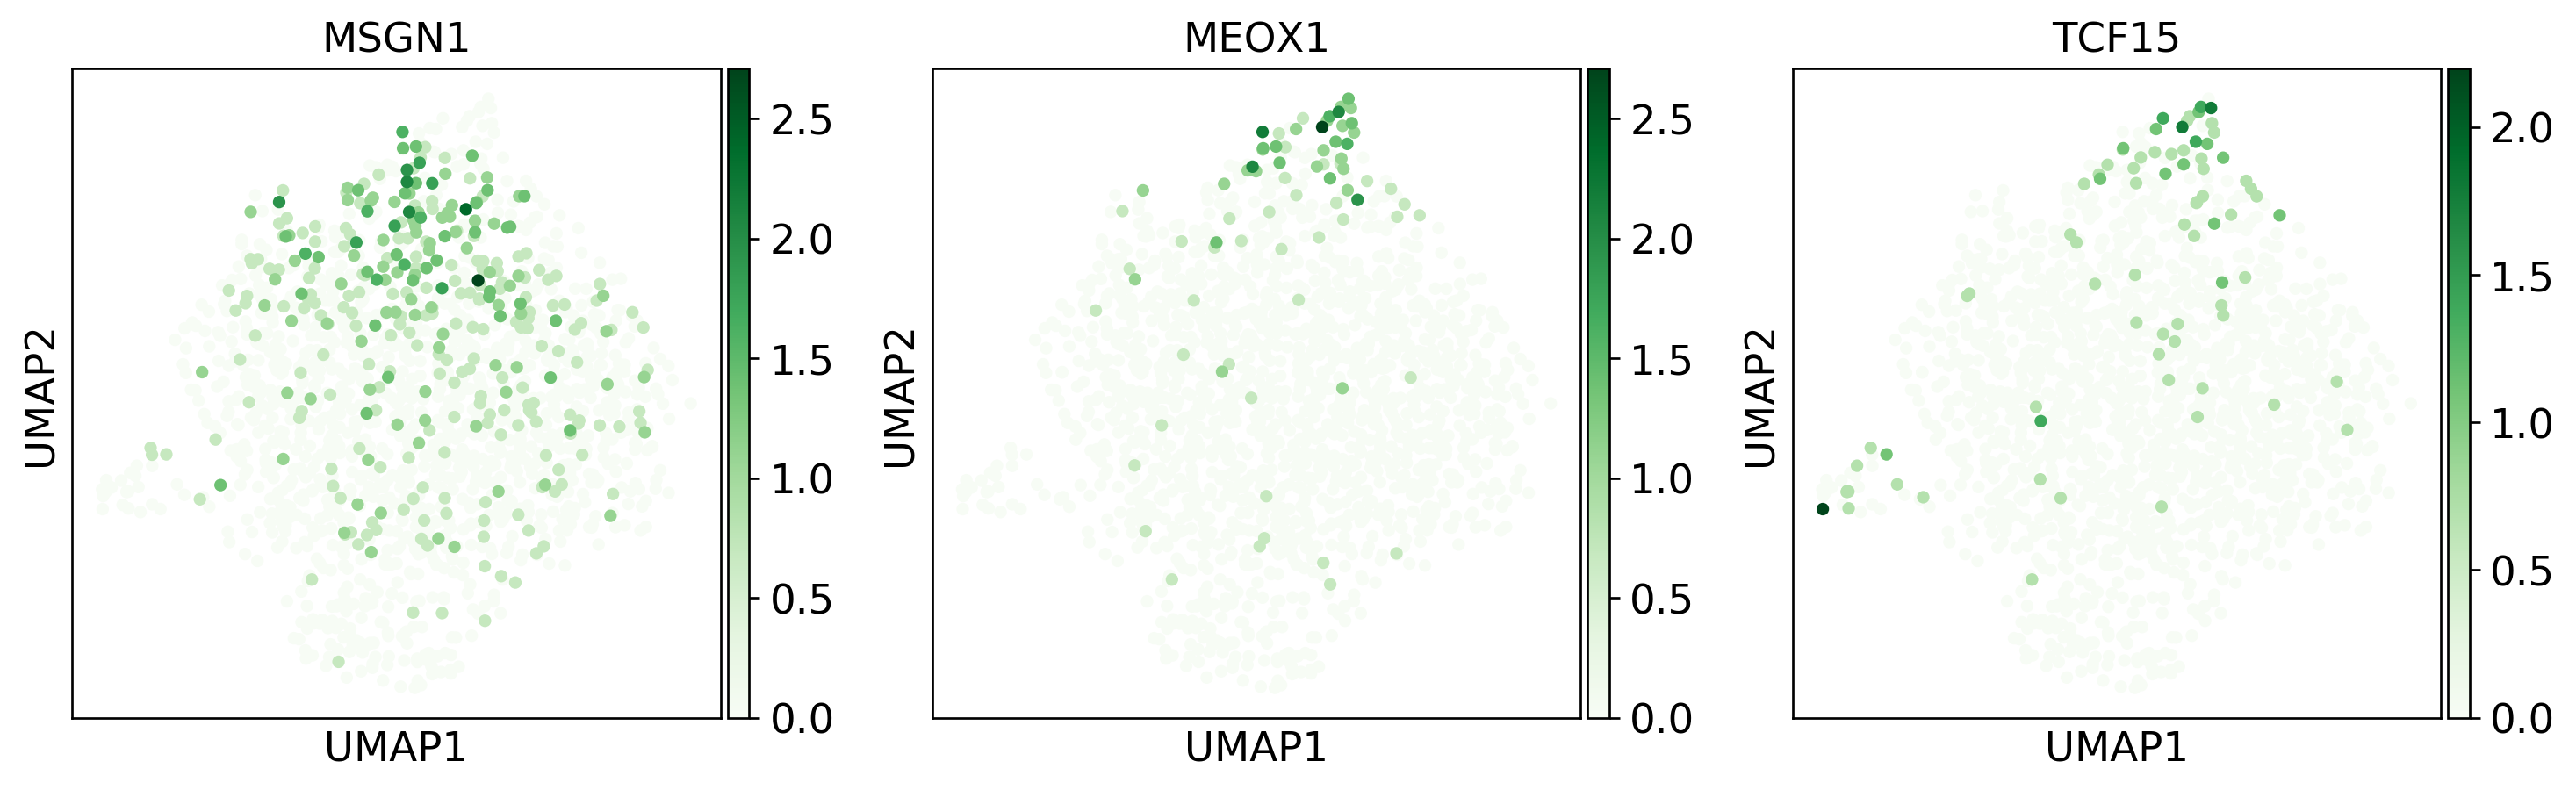

In [57]:
# Overlay genes
sc.pl.umap(mmES, color=['MSGN1','MEOX1', 'TCF15', ], cmap='Greens')

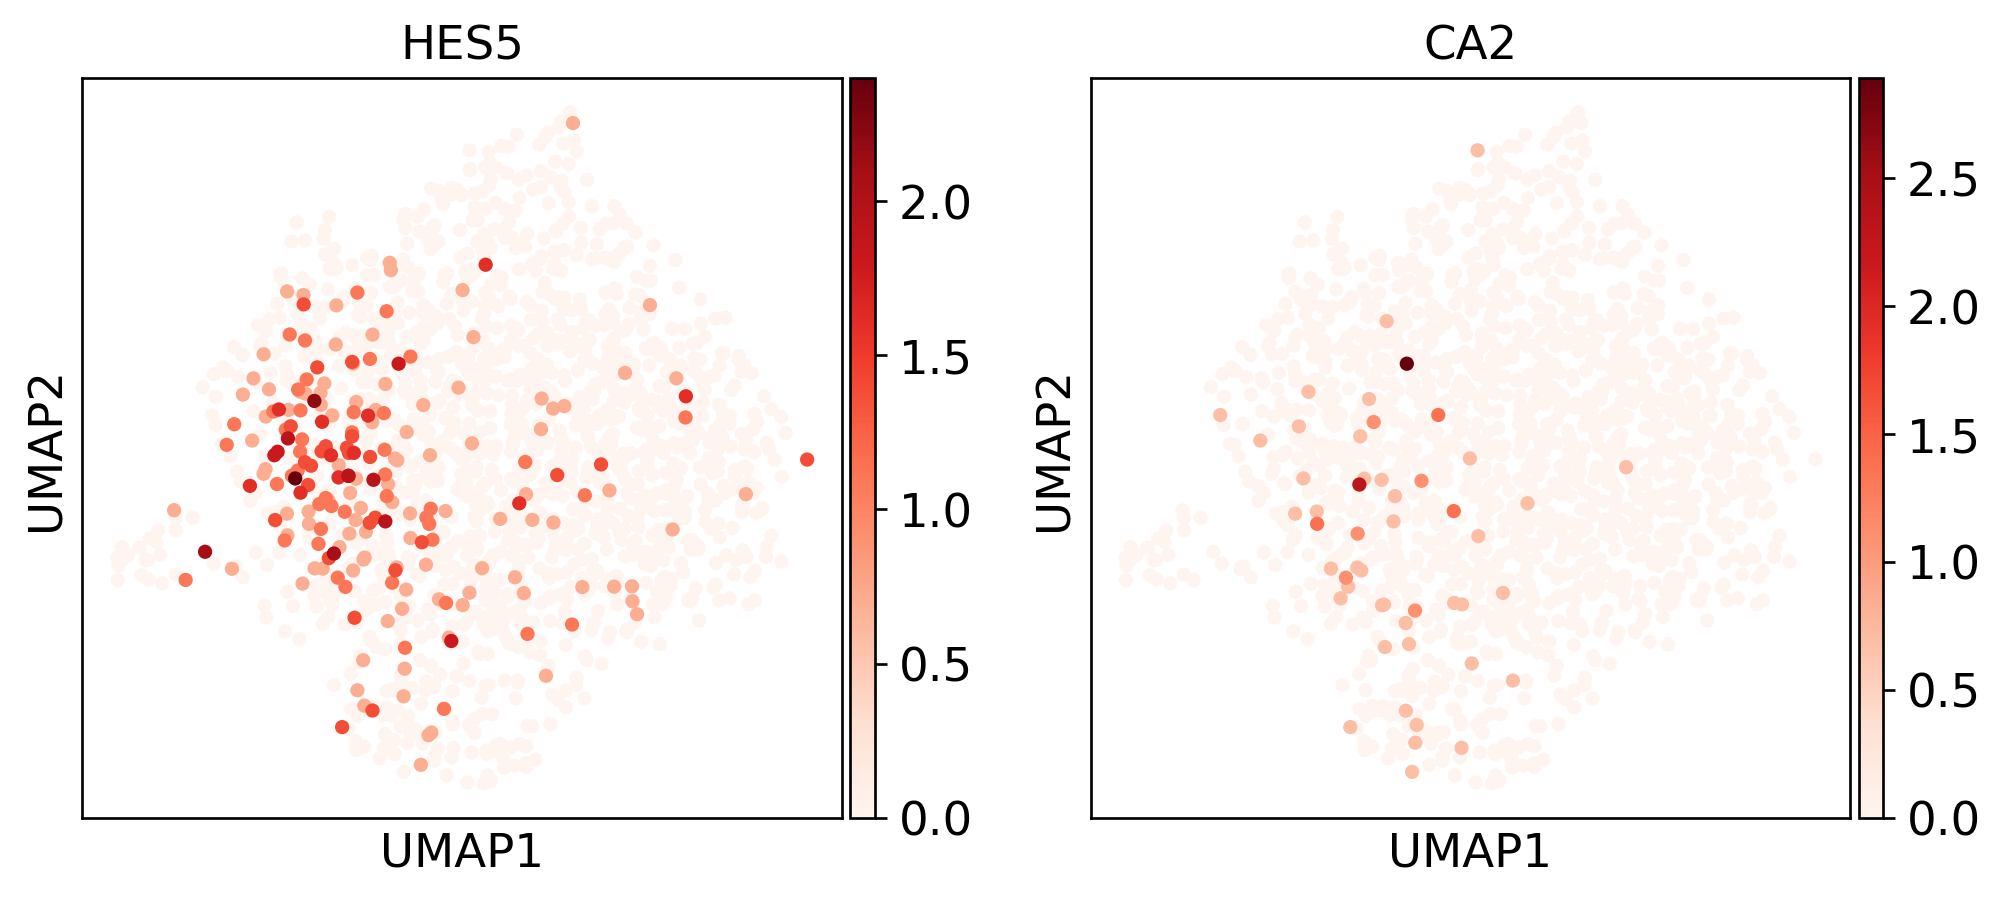

In [58]:
 # Overlay genes
sc.pl.umap(mmES, color=['HES5','CA2',], cmap='Reds')

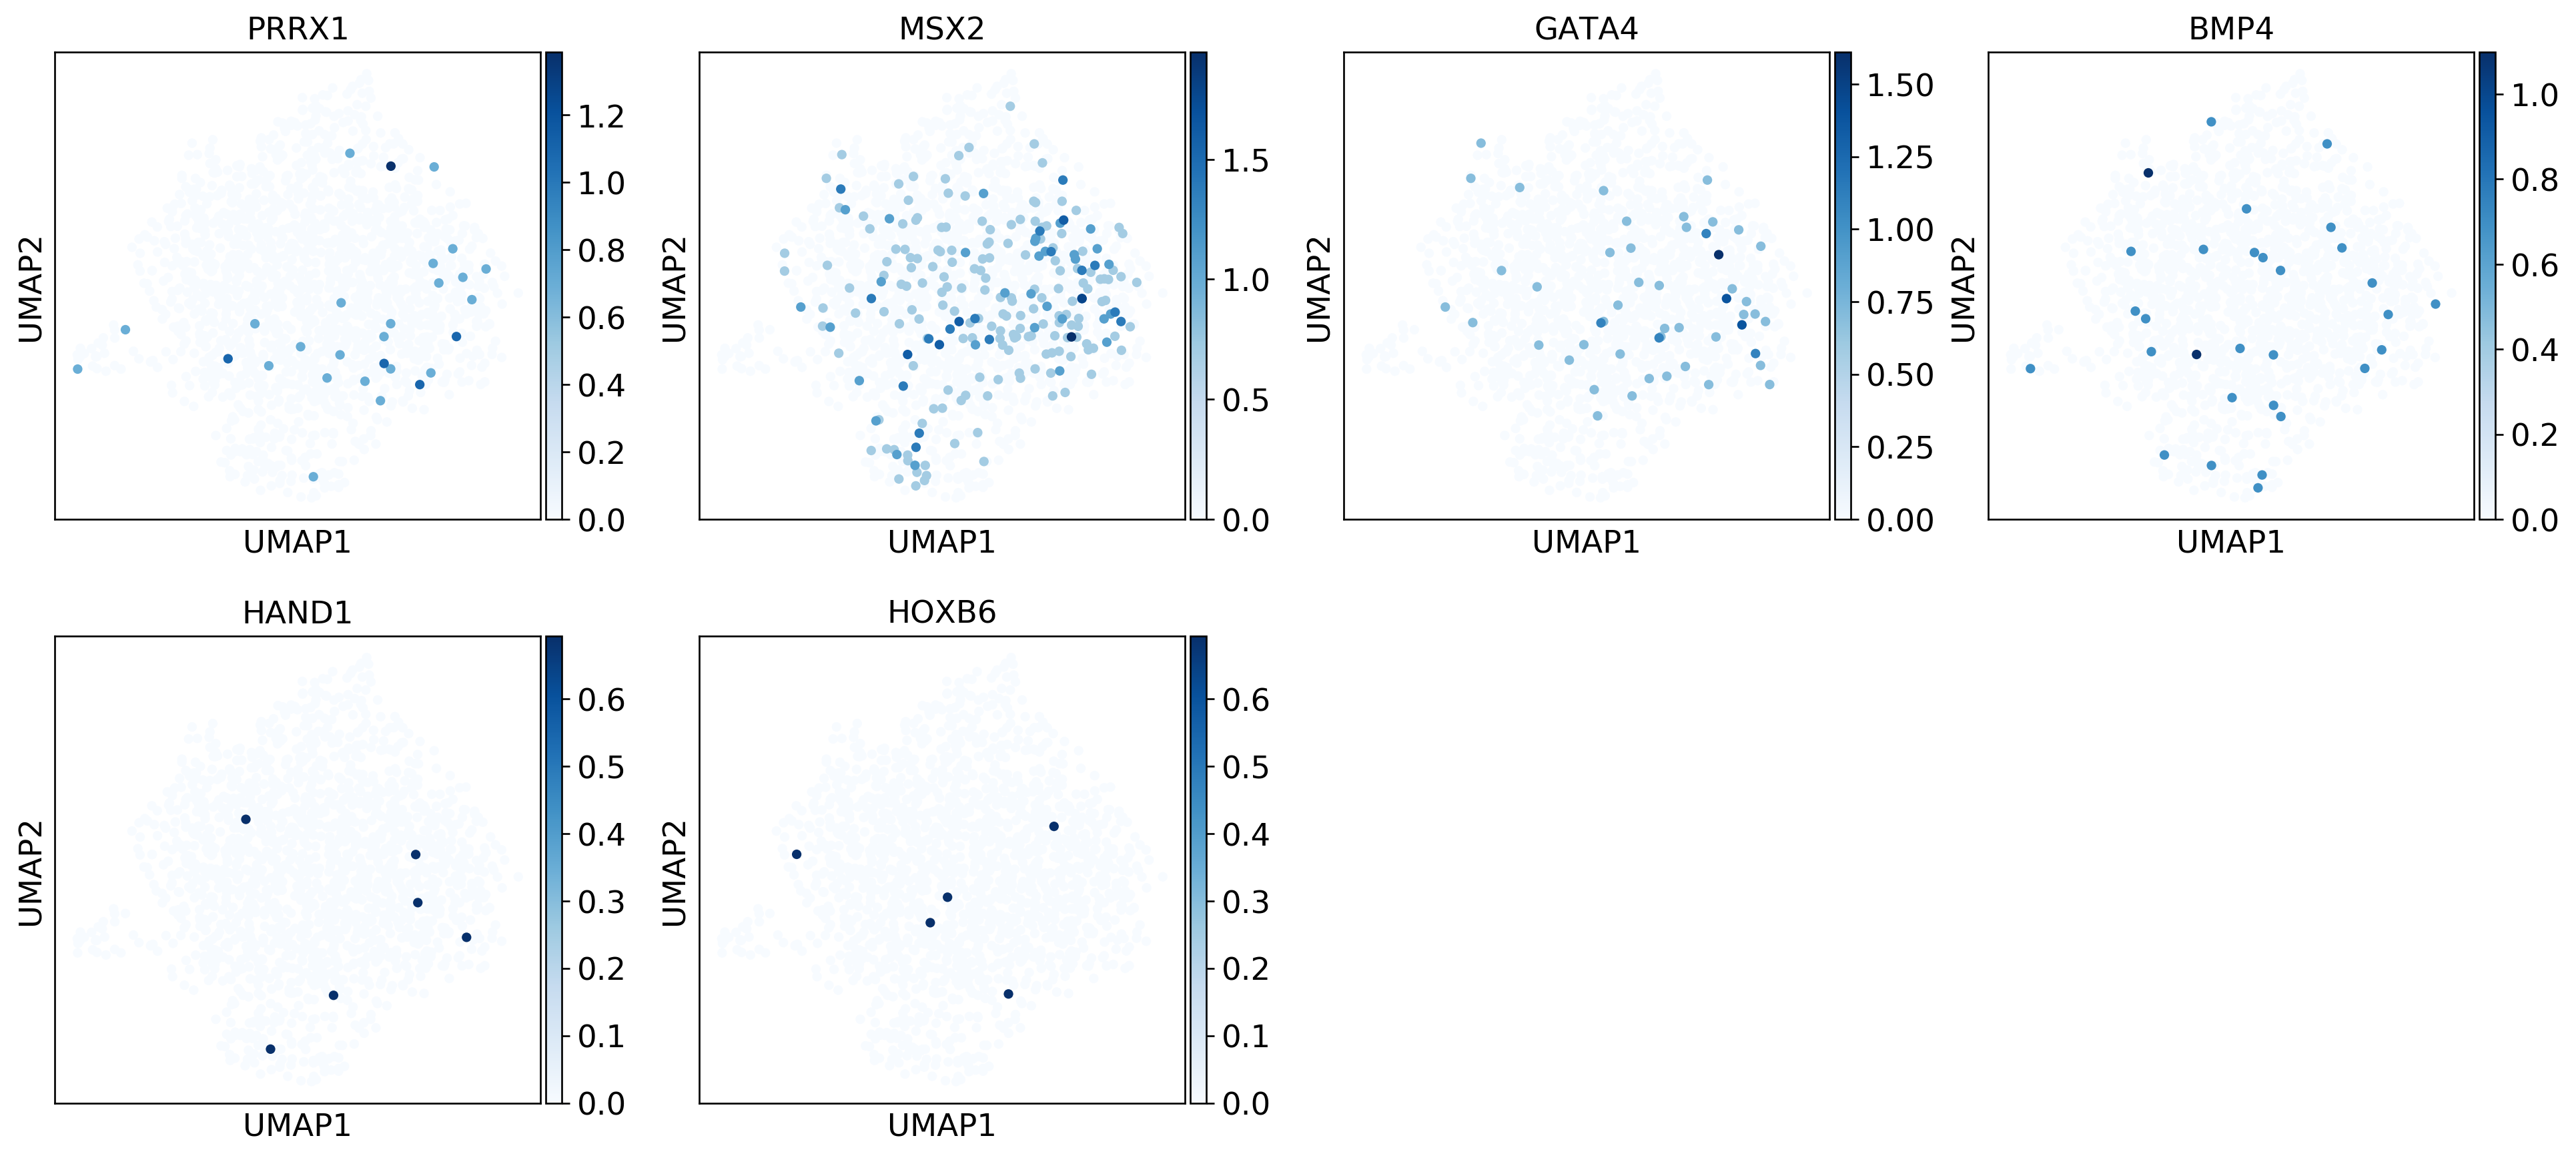

In [59]:
 # Overlay genes
sc.pl.umap(mmES, color=['PRRX1', 'MSX2','GATA4','BMP4','HAND1','HOXB6'], cmap='Blues')

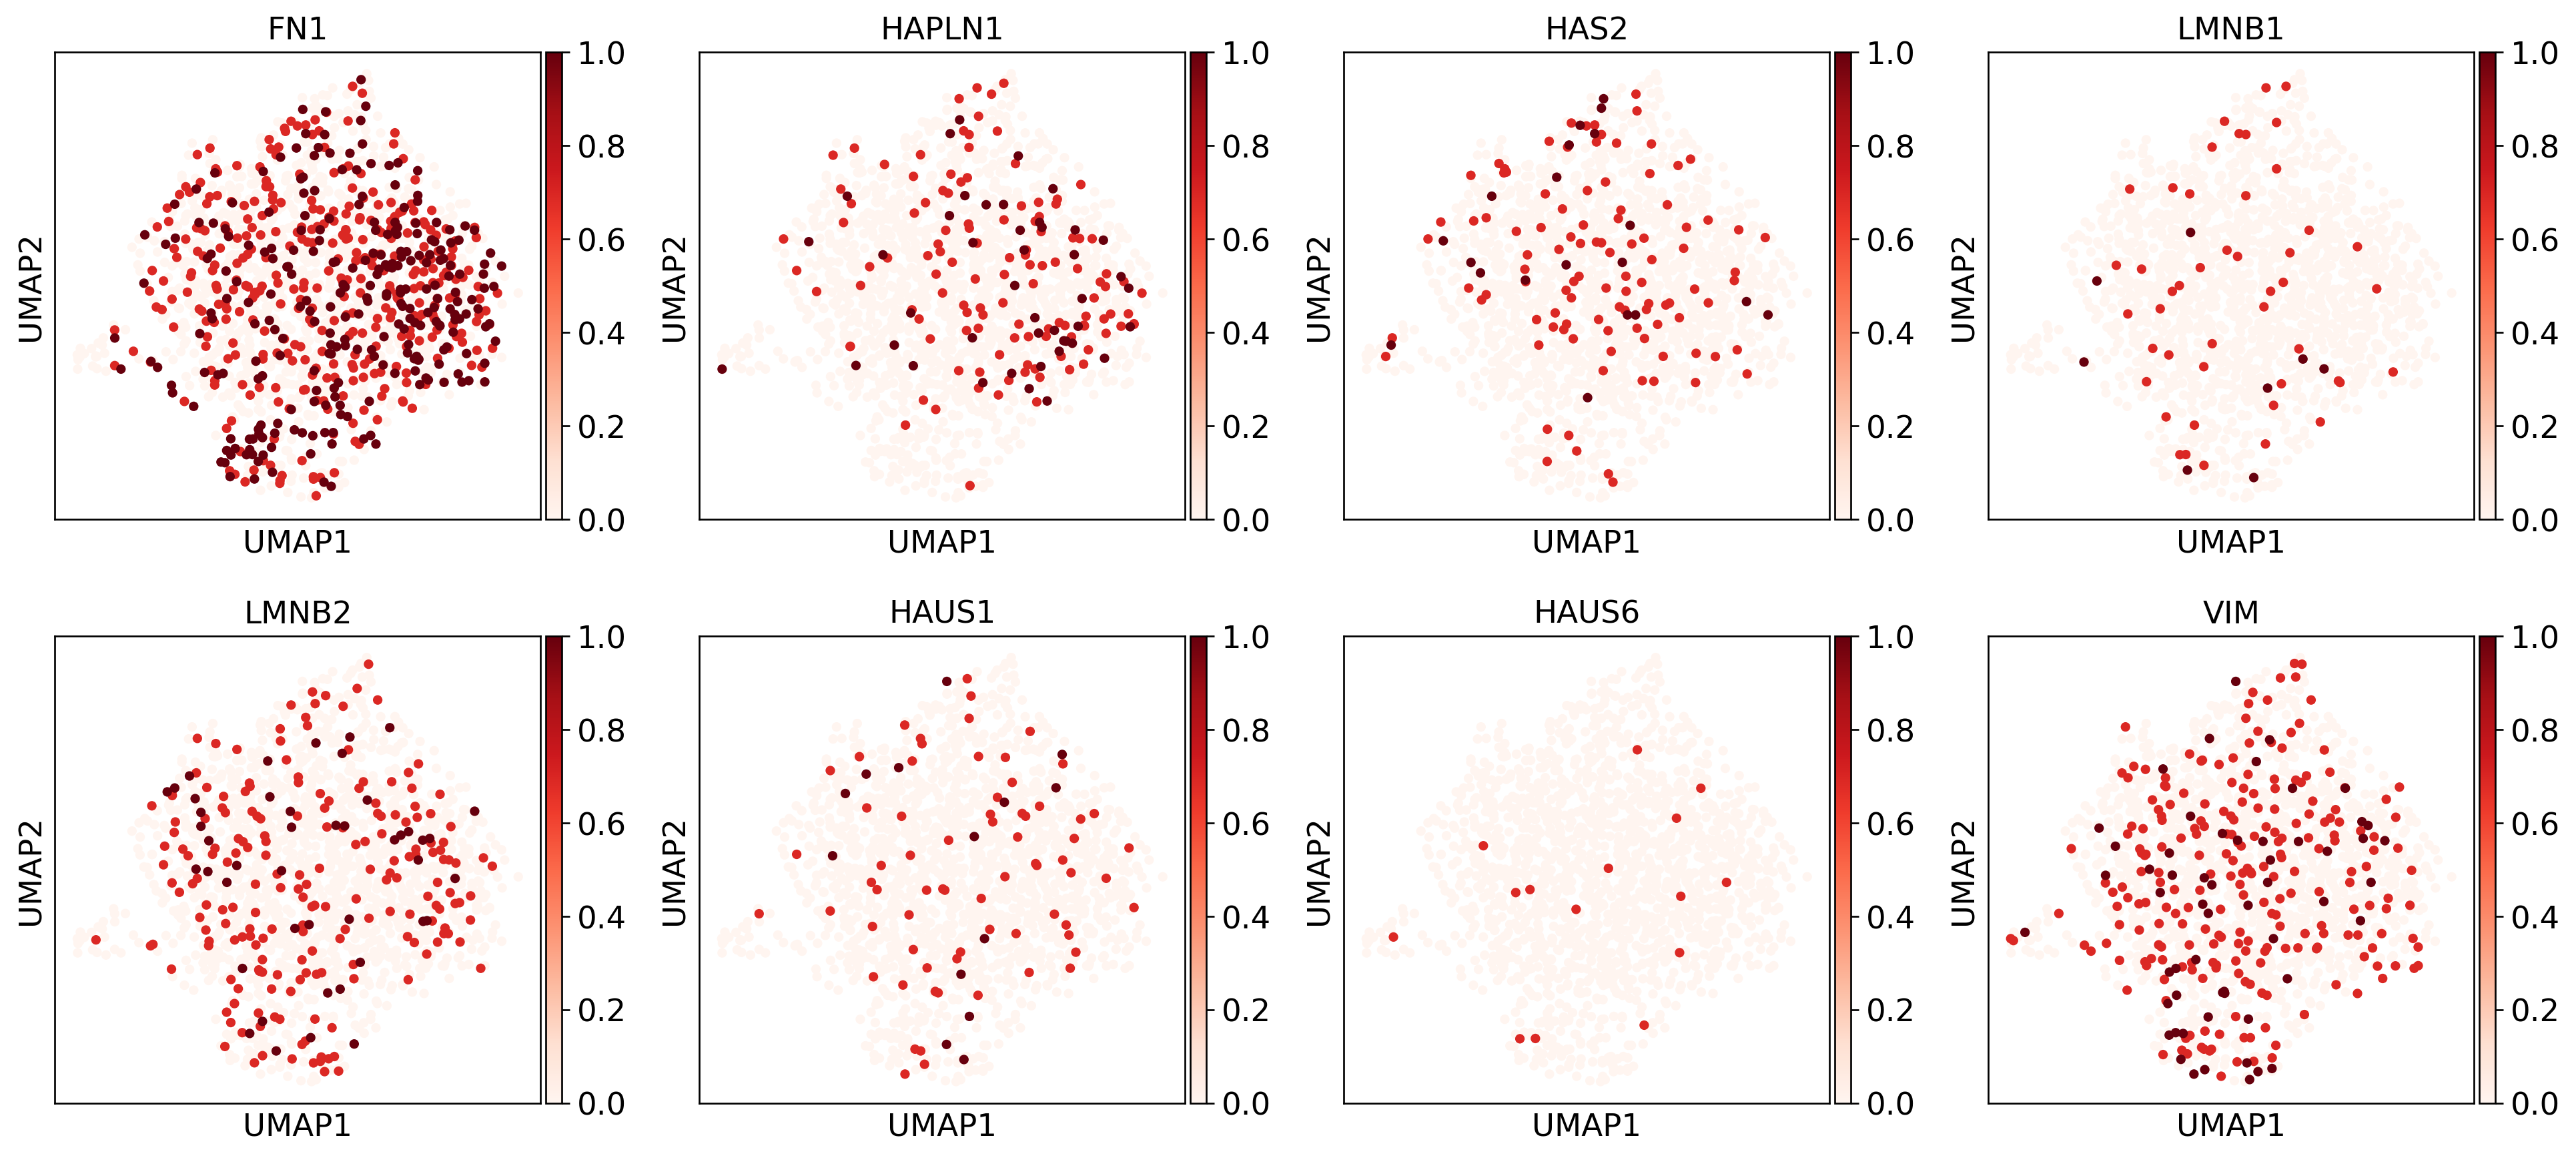

In [60]:
 # Overlay genes
sc.pl.umap(mmES, color=['FN1', 'HAPLN1','HAS2','LMNB1','LMNB2','HAUS1','HAUS6','VIM'], cmap='Reds',vmax=1)

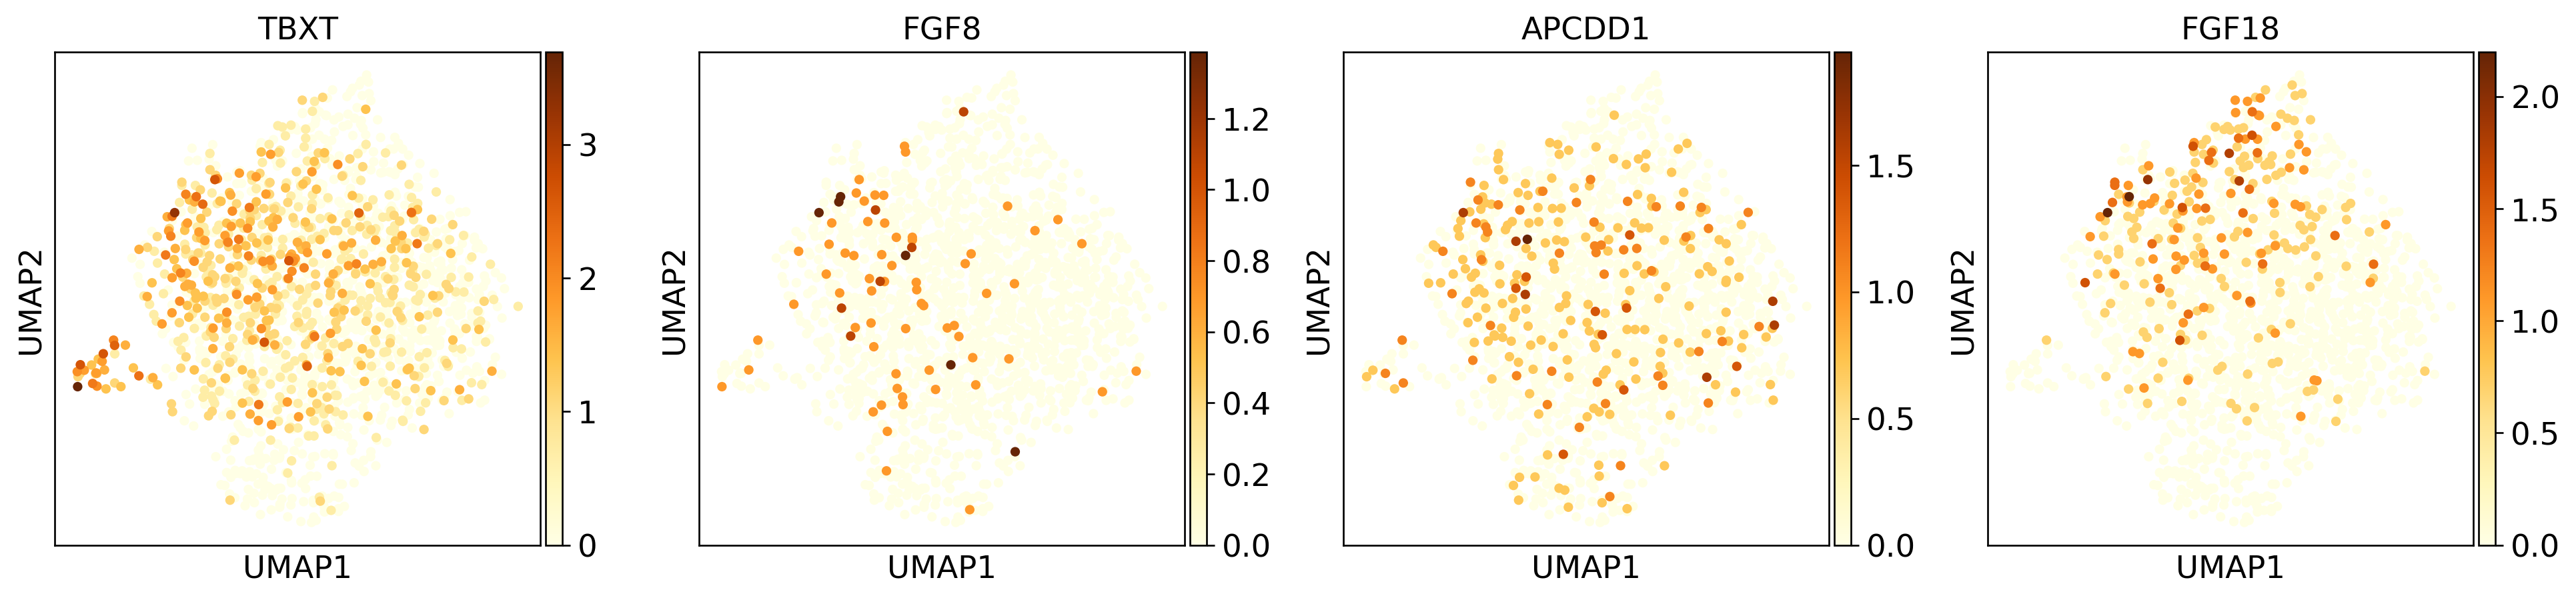

In [61]:
# Overlay genes
sc.pl.umap(mmES, color=['TBXT','FGF8','APCDD1','FGF18'], cmap='YlOr\
Br')

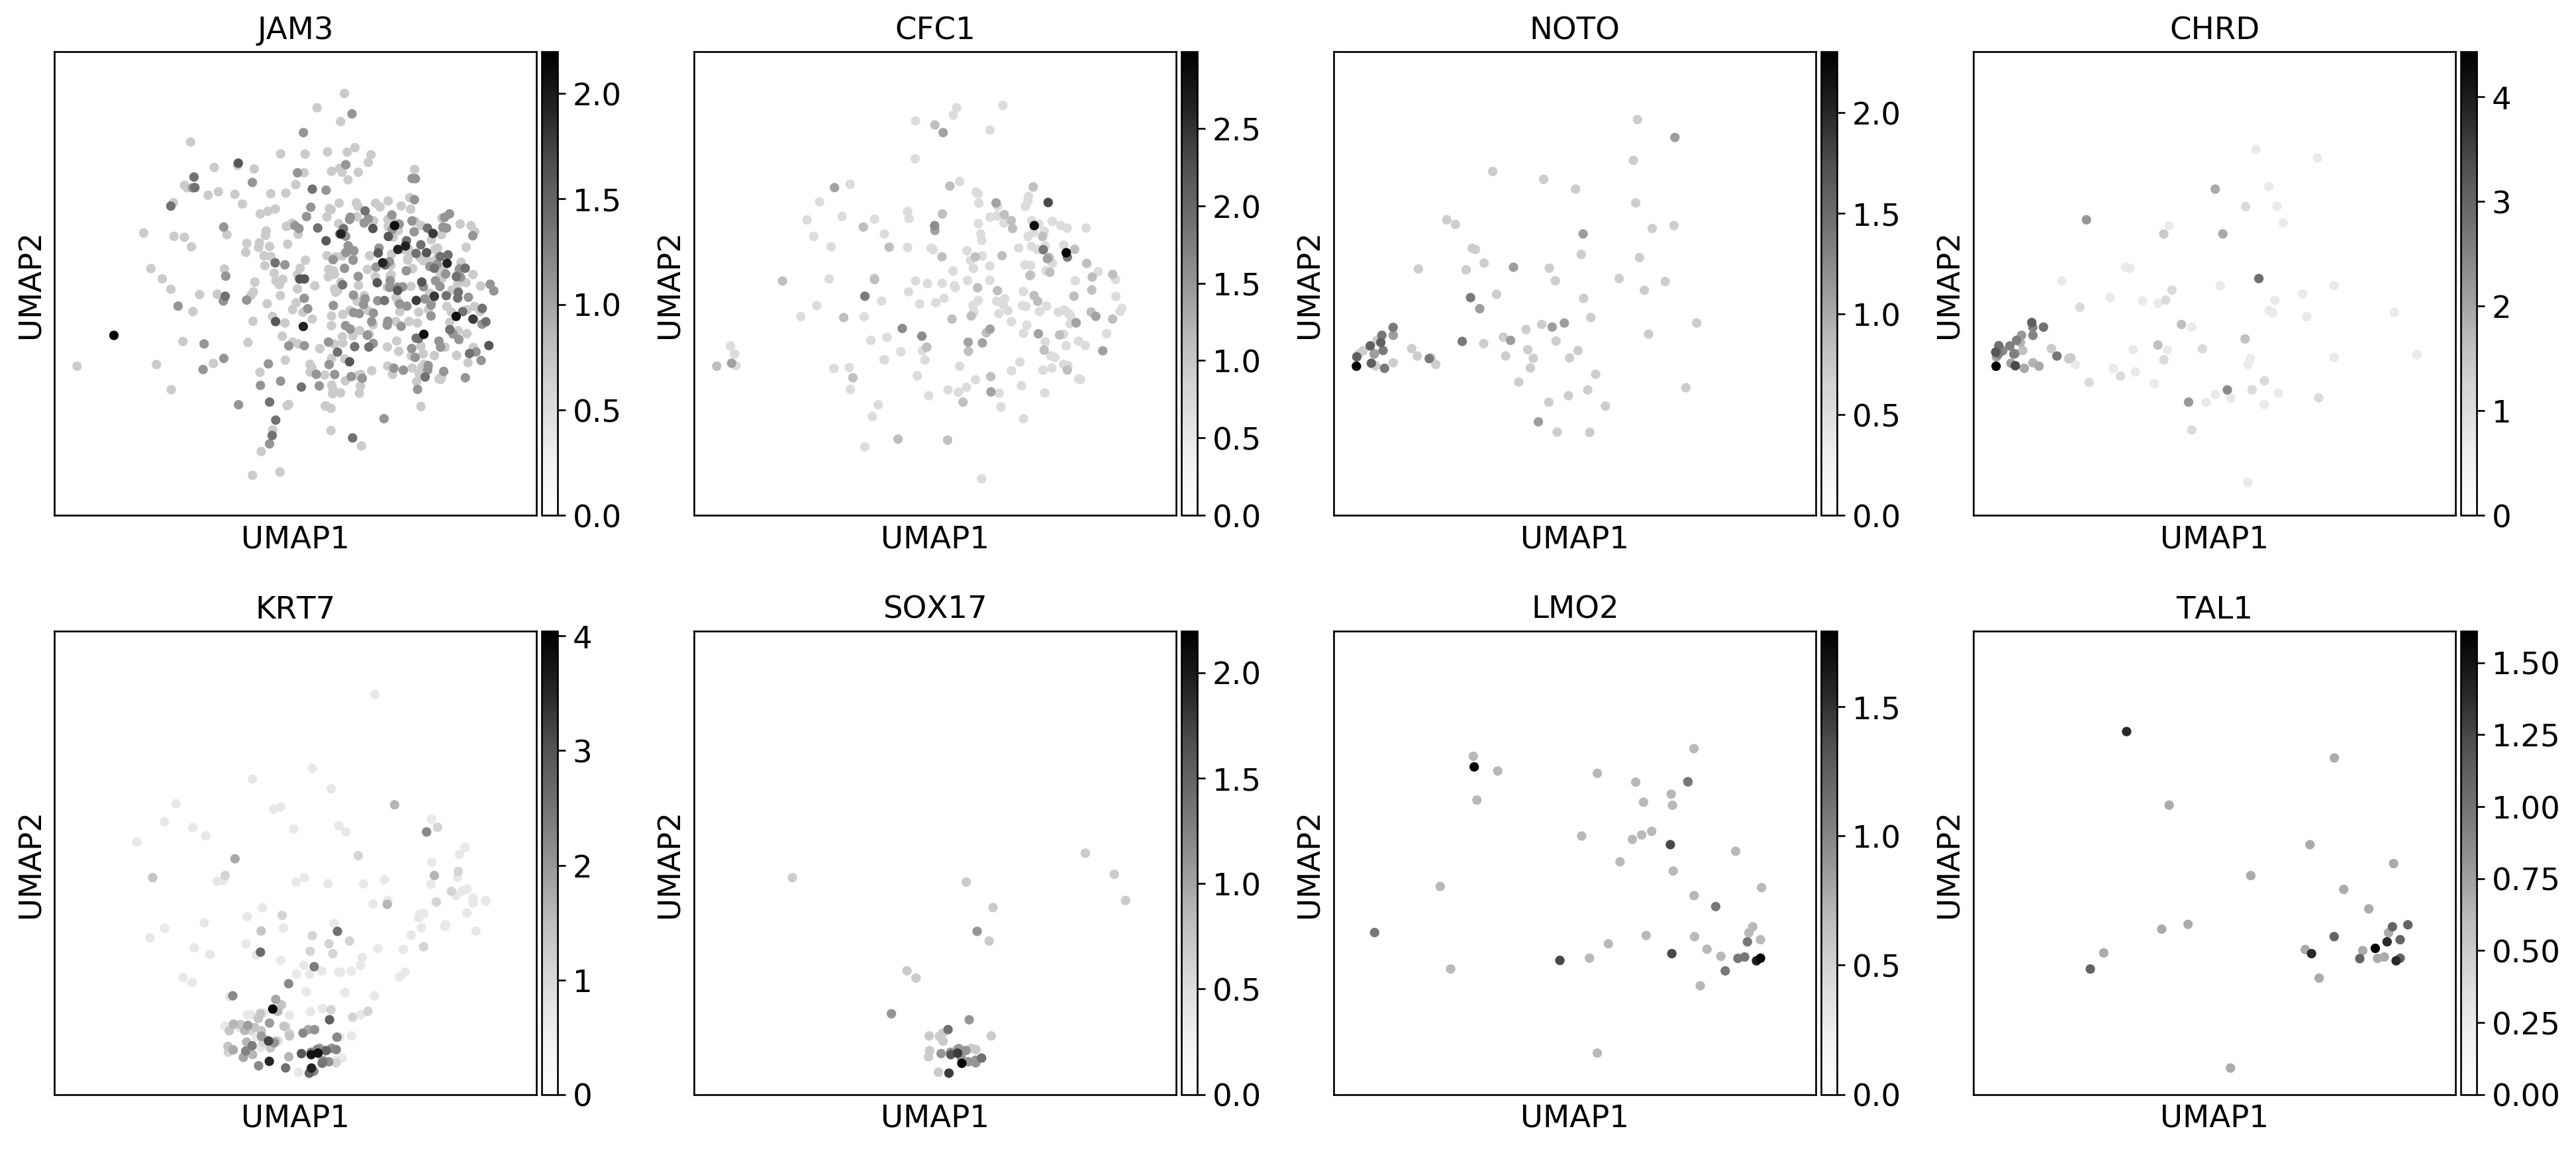

In [62]:

sc.pl.umap(mmES, color=['JAM3','CFC1','NOTO','CHRD','KRT7','SOX17','LMO2','TAL1',], cmap='Greys')

### Perform Clustering

In [71]:
# Leiden and Louvain clustering
sc.tl.leiden(mmES, resolution=0.78, use_weights=True)

running Leiden clustering
    finished (0:00:00)


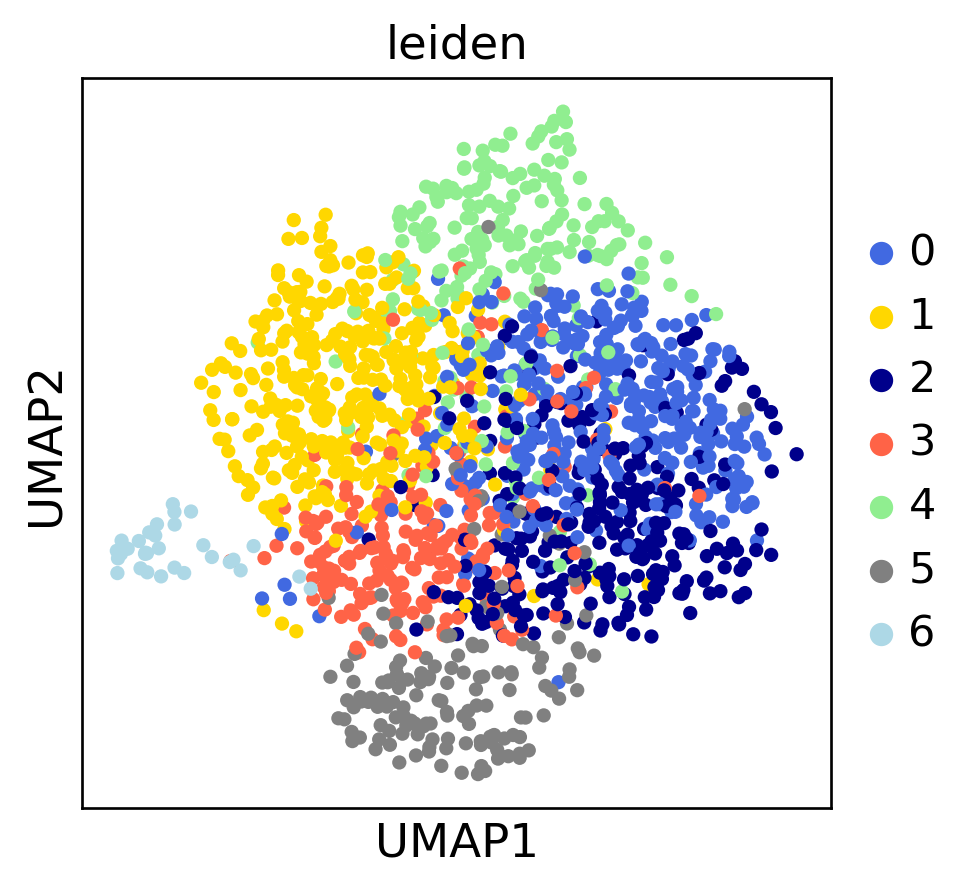

In [101]:
#Plot clusters on UMAP
#sc.tl.umap(mmES, )
sc.pl.umap(mmES, color=['leiden'], palette=[  'royalblue','gold',  'darkblue','tomato', 'lightgreen', 'grey','lightblue','tan','seagreen','pink', 'orange', 'silver', 'skyblue','deepskyblue', 'grey', 'white', 'white','darkgreen', 'white', 'white', 'white', 'white', 'white',])

In [108]:
# Print the top enriched genes in each of the 12 Louvain clusters
sc.tl.rank_genes_groups(mmES, 'leiden')
pd.DataFrame(mmES.uns['rank_genes_groups']['names']).head(50)

ranking genes
    finished (0:00:00)


0         1            2         3           4         5  \
0       JAM3      TBXT        PITX2     FABP5         PTN      KRT7   
1     AKAP12      HES5         JCAD     CALM2     ALDH1A2     KRT18   
2       P4HB      CDH2         RHOU       SET       MEOX1     KRT19   
3       CFC1    NKAIN4         JAM3       CA2        RNH1    EIF4A2   
4        KDR      DLL1        SEPT9     SRSF1       FGF18     NDRG1   
5       MSX1     CLDN1         LMO2       OAT       TCF15     CSRP2   
6       MSX2     APLP2         TAL1      GNL3       MSGN1     CALM2   
7     NUCKS1    CHST15       METRNL  HSP90AA1       SMOC1      MYL9   
8     TUBA1C     HOXA7        FIBIN      RPS2      DCBLD2    LGALS3   
9      FIBIN       WLS        TGFBI     HOXB7       LRIG3     LASP1   
10       FN1     HOXA4       MRPS22     PLPP1        DLL1      GPX1   
11     EEF1D     FGF19         CCM2     CASP2      NOTCH1     SOX17   
12   BHLHE22    TMEM64        CDCA9   TBC1D15     TMEM100     PLPP1   
13     SMAD6    DRAXIN        KRT19    UCH-L1       OLFM1     PAICS   
14     GATA5      LMO4       PHLDA2    MRPL14    Meis2a.2    PABPC1   
15     UNC5B     FGF18        SMAD6    NDUFA6       FGFR1    IGFBP2   
16       ID2      LFNG        CDH11    SNRPD1        LBX2   TMSB15B   
17  CDC42EP4    NOTCH1          HLX    EIF4G2     PPFIBP1    DBNDD2   
18   RASGRP3    APCDD1        SCLT1      RPA3       CADM1       DMD   
19     MFGE8     WNT8A         ETS1   PRELID1      CYB5R3     YWHAQ   
20     BAMBI      NPM3         HPDL     TRIB2        GBX2       ID3   
21     HOXD8      GAD1       GAREM1     KPNA2        GDF3     PDGFA   
22    HAPLN1     F2RL1        HOXB5     KDM3A       CDH20     ANXA2   
23   CLEC19A      FGF8       HAPLN1    ARPP19       STRA6     ESRP2   
24     HOXA9    COL1A2       HMGCS1     CLDN1       APLP2    RANBP1   
25     RBBP6     EPHA1        TAF12       GAL       FGFR3      RPS2   
26   TMEM116     PSIP1        DNAH5    ANP32E        PRTG  HSP90AA1   
27      EEF2     MESP1        ATAD2     SIKE1      ZNF503     AIF1L   
28      CDH2      PRTG        KRT18      PCNA        CDH2       RGN   
29     CCND3    TUBA1A          TRH   WASHC2C        NEBL    TRARG1   
30      LDHB     HOXB7        FAHD1     FABP7      NUCKS1    CAPZA2   
31      RORA      NME2         GFM1    DPH3P1    TMEM120A     EPCAM   
32     MESP1   PEA15L2        MSMO1    KATNB1       UBE2H     CLDN3   
33    ENTPD1      GJA1        ACSS3      MLH3       RSPO3     CIRBP   
34   FAM169A     SALL1        REXO4     TNNC1     TMEM35B     PSMA1   
35     PMP22      NASP         SVIL     HSPE1  ST6GALNAC2    TFAP2A   
36     WDR60     PARP1         MSX1    PABPC1      POLR2M       EZR   
37       NDP      SDC3        BAMBI   SLC25A5       P4HA2   ATP5MC3   
38     MED27     WNT3A       MRPL21     ACTR8        PRCP    VPS26A   
39  TMEM161A    NT5DC2       EXFABP     G3BP1        MID1      EIF5   
40    TMEM37     TMED2  C11H16ORF87     PCBP2       EIF5B  PAFAH1B2   
41      PMVK     HOXB8    C1GALT1C1    AKR1E2        SIK1     BASP1   
42    SMAD2Z     NRXN1         AMN1      NMT2         FST    TUBB2B   
43     TGFB2     LRTM1        GATA4     WDR43        LEF1     HSPE1   
44      UBR1  VKORC1L1        PCSK7     ACACA      ADGRL2    AKR1D1   
45      NIP7     PALD1       MTRF1L     OLFM1         SP5      DAG1   
46     HOXB5     CARS2         SGCG     CAND1        CLTB      TJP2   
47     MAGI3     RAI14       MAD1L1     PDGFA       HSPG2    GUCA2A   
48      HSF3     CSDC2        BBOX1    POLR2E        ZEB2    RPS15A   
49    TMEM57    AKAP12        FARP1     MGME1       MEX3A      TGM2   

                 6  
0             CHRD  
1             TBXT  
2             NOTO  
3              NOV  
4             CA10  
5              LTF  
6           ERGIC2  
7            SMOC1  
8            HSPA5  
9   angiopoietin-2  
10           STRA6  
11           SPARC  
12           H3F3B  
13            HES4  
14           APLP2  
15            CDH2  
16           POSTN  
17         

In [109]:
sc.tl.rank_genes_groups(mmES, 'leiden', use_raw=True, groups='all', reference='rest', n_genes=1000, 
      method='wilcoxon', corr_method='benjamini-hochberg', log_transformed=True)

ranking genes
    finished (0:00:00)


In [110]:
# Generate a tables of differentially expressed genes for each group
deg = mmES.uns['rank_genes_groups']
groups = deg['names'].dtype.names

# Format a table with top 20 gene names only, export to PDFs
for j in range(len(groups)):
    df_names_only = pd.DataFrame({groups : deg[key][groups] for groups in [groups[j]] for key in ['names']}).head(20)
    html_names_only = df_names_only.style.set_table_styles([{'selector': 'th', 'props': [('font-size', '10pt'), ('font-family','Arial'), ('text-align','center'), ('width', '100px')]}]).set_properties(**{'font-size': '10pt', 'font-family': 'Arial', 'text-align': 'center', 'width': '100px'}).set_precision(3).render()
    with open('tables/tmp.html', 'w') as file: file.write(html_names_only)
    #pdf.from_file('tables/tmp.html', 'tables/mmES_DEGNames_chicken_'+groups[j]+'.pdf')

# Format a table with top 100 gene names and corrected p-values, export to excel
df_names_pvals = pd.DataFrame({groups+'_'+key: deg[key][groups] for groups in groups for key in ['names', 'pvals','logfoldchanges']}).head(1000)
df_names_pvals.to_csv('tables/mmES_DEGTable_leiden_chicken6sfinal.csv')



In [78]:
#save the gene list
Louvain_Cluster=pd.DataFrame(mmES.uns['rank_genes_groups']['names'])
#write the saved gene list to a file
Louvain_Cluster.to_csv('/home/pourquielab/Desktop/backup/datachicken/figures/Leiden_chicken6sfinal.csv')


running PAGA
    finished (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


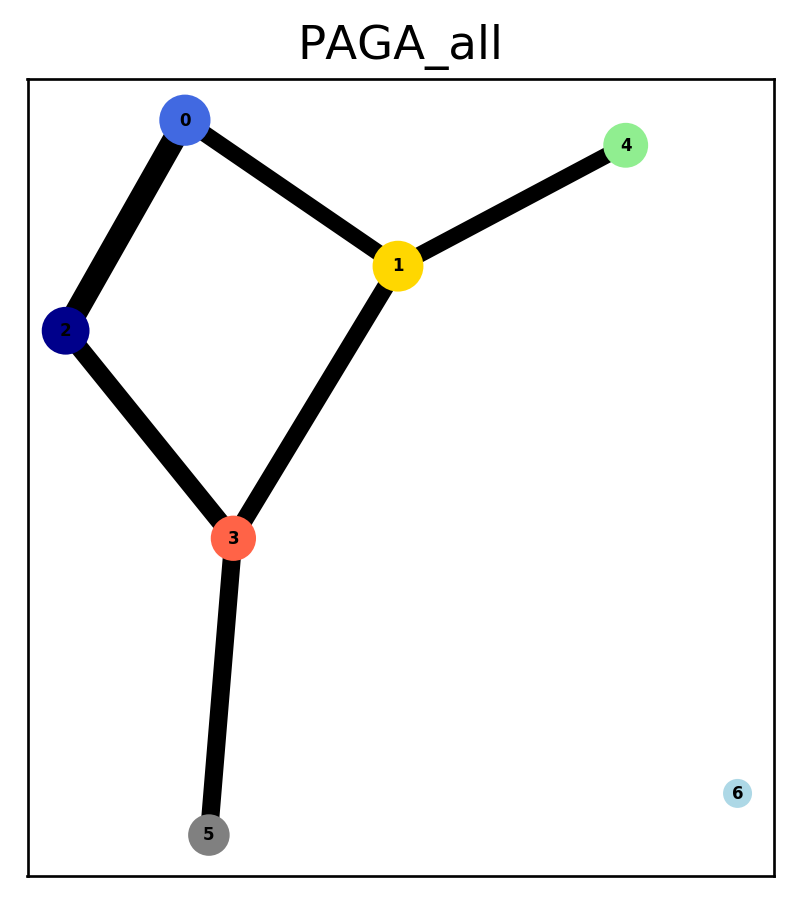

In [107]:
mmES_sub_sub2 = mmES[~mmES.obs['leiden'].isin(['7','8','9','10']),:]
sc.tl.paga(mmES_sub_sub2, groups='leiden')#
sc.pl.paga(mmES_sub_sub2, threshold=0.6, edge_width_scale=1, fontsize=5, show=False, title='PAGA_all')

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.91014475 0.8654749  0.85140777 0.7942946  0.78577524
     0.77708936 0.77147734 0.763633   0.7561815  0.75325704 0.75019747
     0.74572974 0.74299514 0.7399607 ]
    finished (0:00:00)
computing Diffusion Pseudotime using n_dcs=10
    finished (0:00:00)


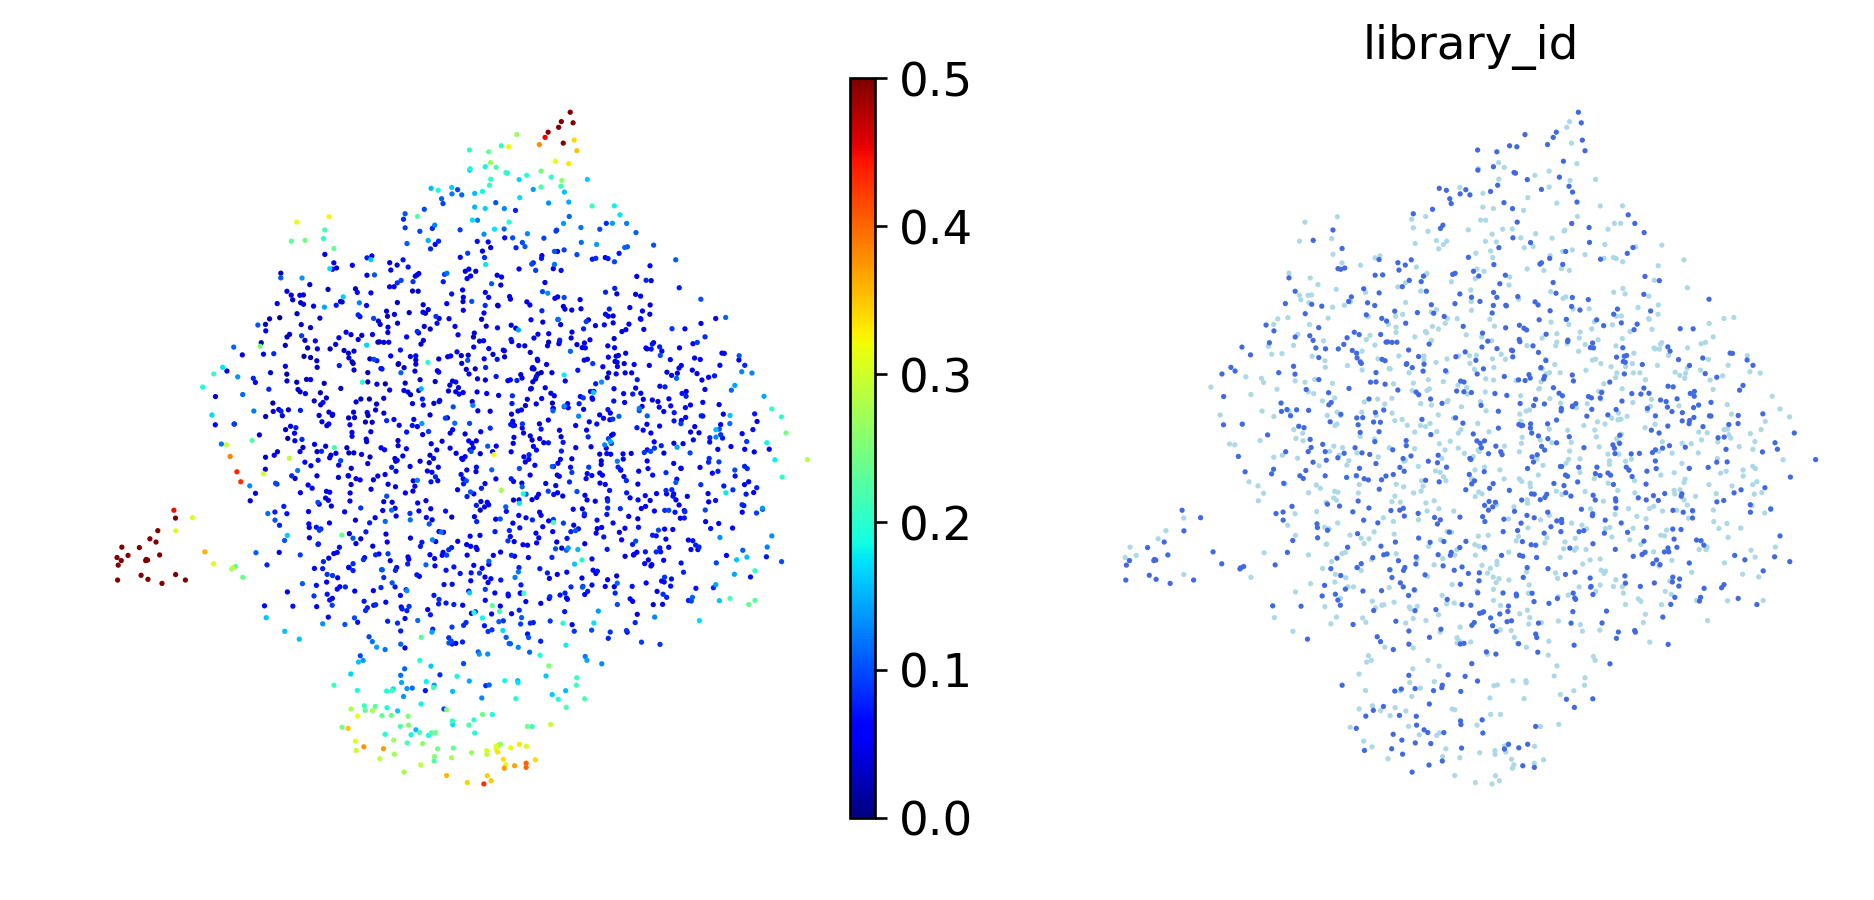

In [80]:

mmES_sub_sub2.uns['iroot'] = np.flatnonzero(mmES_sub_sub2.obs['leiden']  == '1')[40]
sc.tl.diffmap(mmES_sub_sub2,)
sc.tl.dpt(mmES_sub_sub2)

# T
sc.pl.umap(mmES_sub_sub2, color=['dpt_pseudotime','library_id'], size=10, cmap='jet', edges=False, frameon=False, title='', legend_loc='none', legend_fontsize=10, legend_fontweight='medium', show=False, vmax=0.5)




/home/pourquielab/miniconda2/envs/py6/lib/python3.6/site-packages/anndata/core/anndata.py:299: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


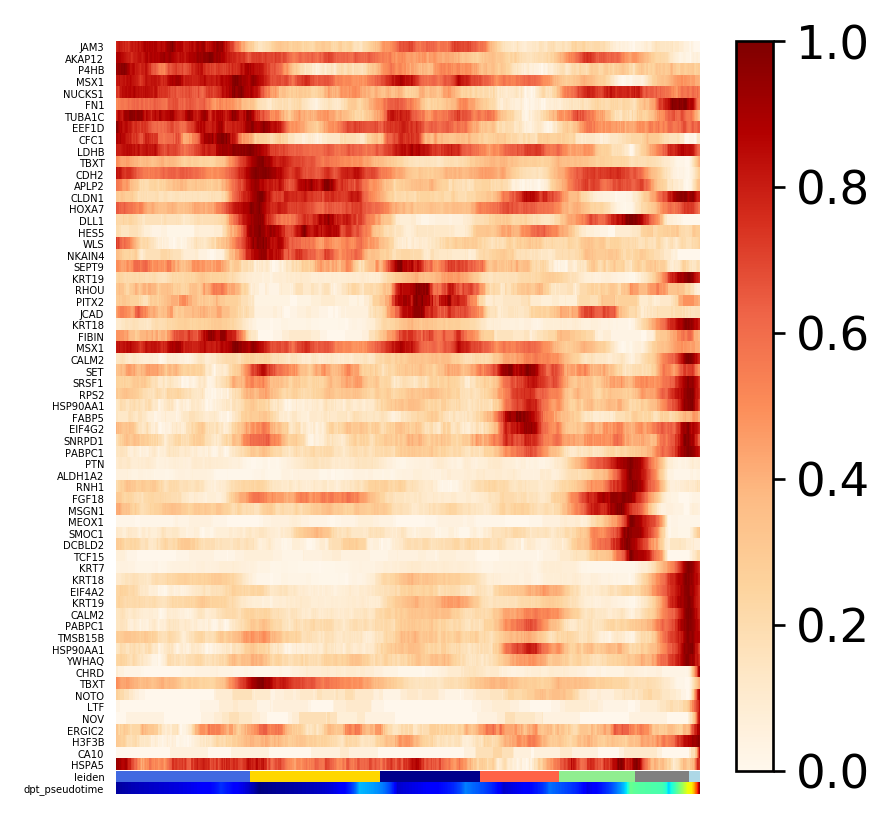

In [87]:
# Plot gene expression trajectories JAM3
traj_nodes = ['0','1','2','3','4','5','6',]
traj_genes = ['JAM3','AKAP12','P4HB','MSX1','NUCKS1','FN1','TUBA1C','EEF1D','CFC1','LDHB','TBXT','CDH2','APLP2','CLDN1','HOXA7','DLL1','HES5','WLS','NKAIN4','SEPT9','KRT19','RHOU','PITX2','JCAD','KRT18','FIBIN','MSX1','CALM2','SET','SRSF1','RPS2','HSP90AA1','FABP5','EIF4G2','SNRPD1','PABPC1','PTN','ALDH1A2','RNH1','FGF18','MSGN1','MEOX1','SMOC1','DCBLD2','TCF15','KRT7','KRT18','EIF4A2','KRT19','CALM2','PABPC1','TMSB15B','HSP90AA1','YWHAQ','CHRD','TBXT','NOTO','LTF','NOV','ERGIC2','H3F3B','CA10','HSPA5']
ax = sc.pl.paga_path(mmES_sub_sub2, nodes=traj_nodes, keys=traj_genes, use_raw=True, annotations=['dpt_pseudotime'],
                     color_map='OrRd', color_maps_annotations={'dpt_pseudotime': 'jet'}, palette_groups=None, 
                     n_avg=100, groups_key=None, xlim=[None, None], title=None, left_margin=None, ytick_fontsize=3, 
                     title_fontsize=None, show_node_names=False, show_yticks=True, show_colorbar=True, legend_fontsize=1, 
                     legend_fontweight=None, normalize_to_zero_one=True, as_heatmap=True, return_data=False, show=True, ax=None)

#plt.savefig('figures/paga_path_marker_genes.png', dpi=2000, bbox_inches='tight')


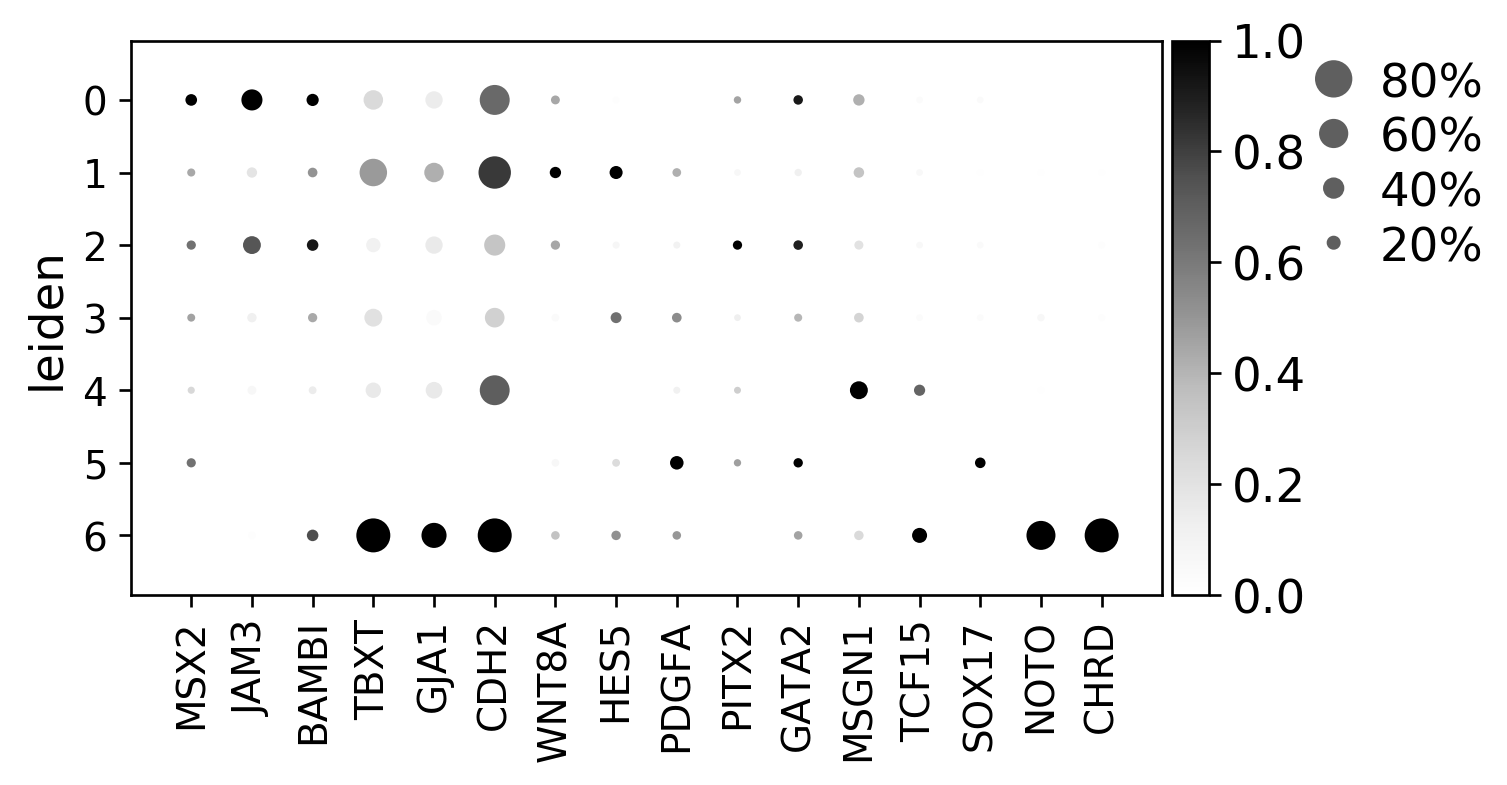

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[5.6, 0, 0.2, 0.5, 0.25])

In [88]:
# Generate Dot Plots
mouse_hox=['MSX2','JAM3','BAMBI','TBXT','GJA1', 'CDH2', 'WNT8A','HES5','PDGFA','PITX2','GATA2','MSGN1','TCF15','SOX17','NOTO','CHRD',]
# Generate Dot Plots

sc.pl.dotplot(mmES_sub_sub2, mouse_hox, groupby='leiden',  log=True, num_categories=6, 
              expression_cutoff=0.0, mean_only_expressed=None, color_map='Greys', dot_max=0.8, 
              dot_min=None, figsize=None, dendrogram=None, gene_symbols=None, var_group_positions=None, 
              standard_scale='var', smallest_dot=4, var_group_labels=None, var_group_rotation=None, 
              layer=None, show=None, save='chicken_NMP_dotplot.png')

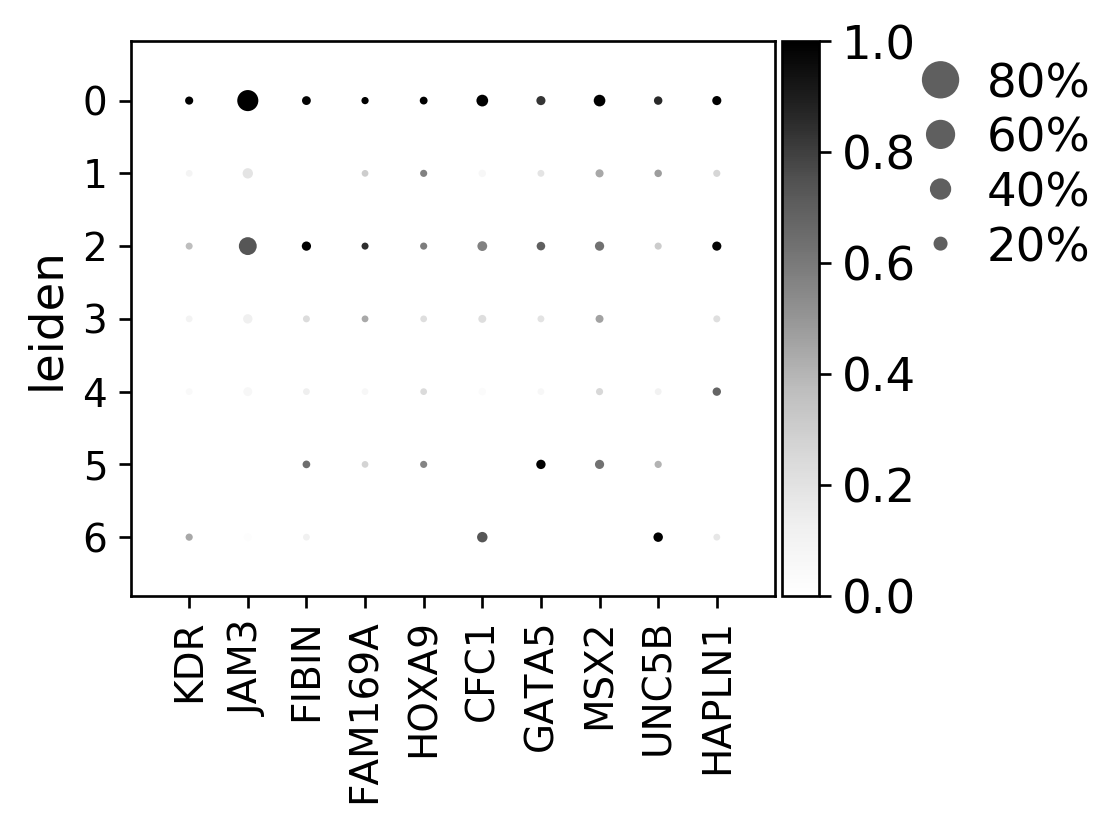

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[3.5, 0, 0.2, 0.5, 0.25])

In [89]:
# Generate Dot Plots
mouse_hox=['KDR','JAM3','FIBIN','FAM169A','HOXA9', 'CFC1', 'GATA5','MSX2','UNC5B','HAPLN1',]
# Generate Dot Plots

sc.pl.dotplot(mmES_sub_sub2, mouse_hox, groupby='leiden',  log=True, num_categories=6, 
              expression_cutoff=0.0, mean_only_expressed=None, color_map='Greys', dot_max=0.8, 
              dot_min=None, figsize=None, dendrogram=None, gene_symbols=None, var_group_positions=None, 
              standard_scale='var', smallest_dot=4, var_group_labels=None, var_group_rotation=None, 
              layer=None, show=None, save='chicken_NMP_dotplot.png')

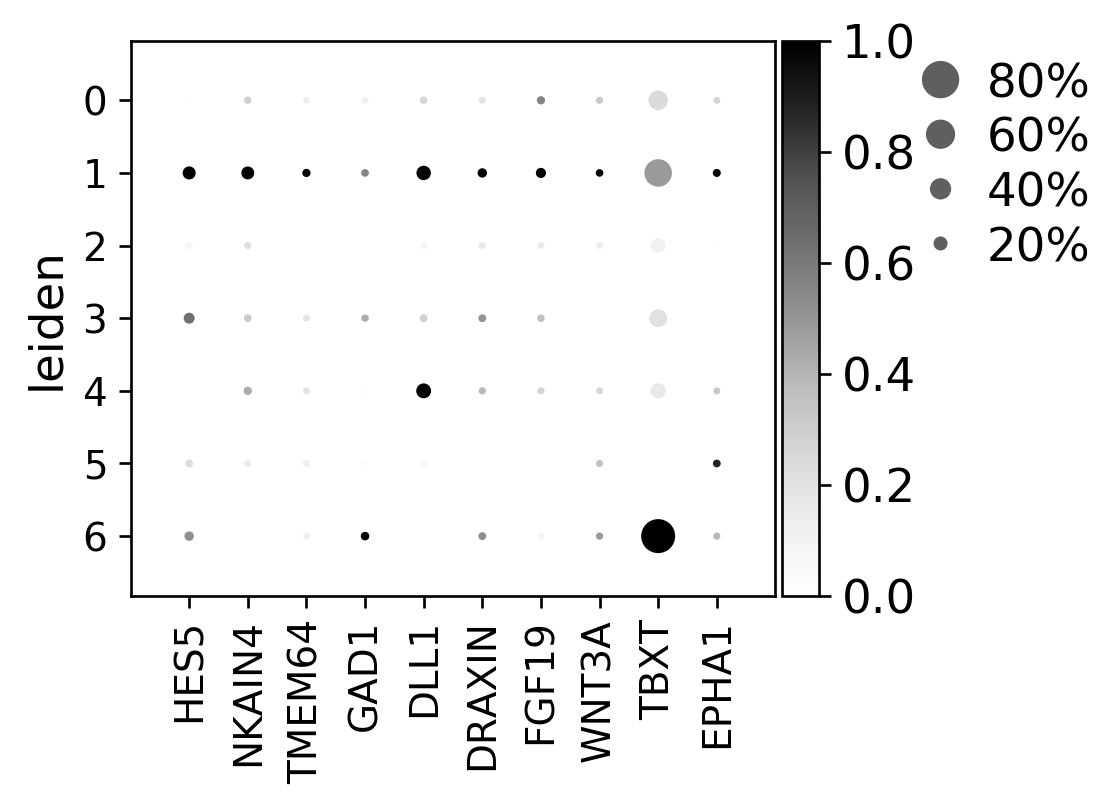

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[3.5, 0, 0.2, 0.5, 0.25])

In [90]:
# Generate Dot Plots
mouse_hox=['HES5','NKAIN4','TMEM64','GAD1','DLL1', 'DRAXIN', 'FGF19','WNT3A','TBXT','EPHA1',]
# Generate Dot Plots

sc.pl.dotplot(mmES_sub_sub2, mouse_hox, groupby='leiden',  log=True, num_categories=6, 
              expression_cutoff=0.0, mean_only_expressed=None, color_map='Greys', dot_max=0.8, 
              dot_min=None, figsize=None, dendrogram=None, gene_symbols=None, var_group_positions=None, 
              standard_scale='var', smallest_dot=4, var_group_labels=None, var_group_rotation=None, 
              layer=None, show=None, save='chicken_NMP_dotplot.png')

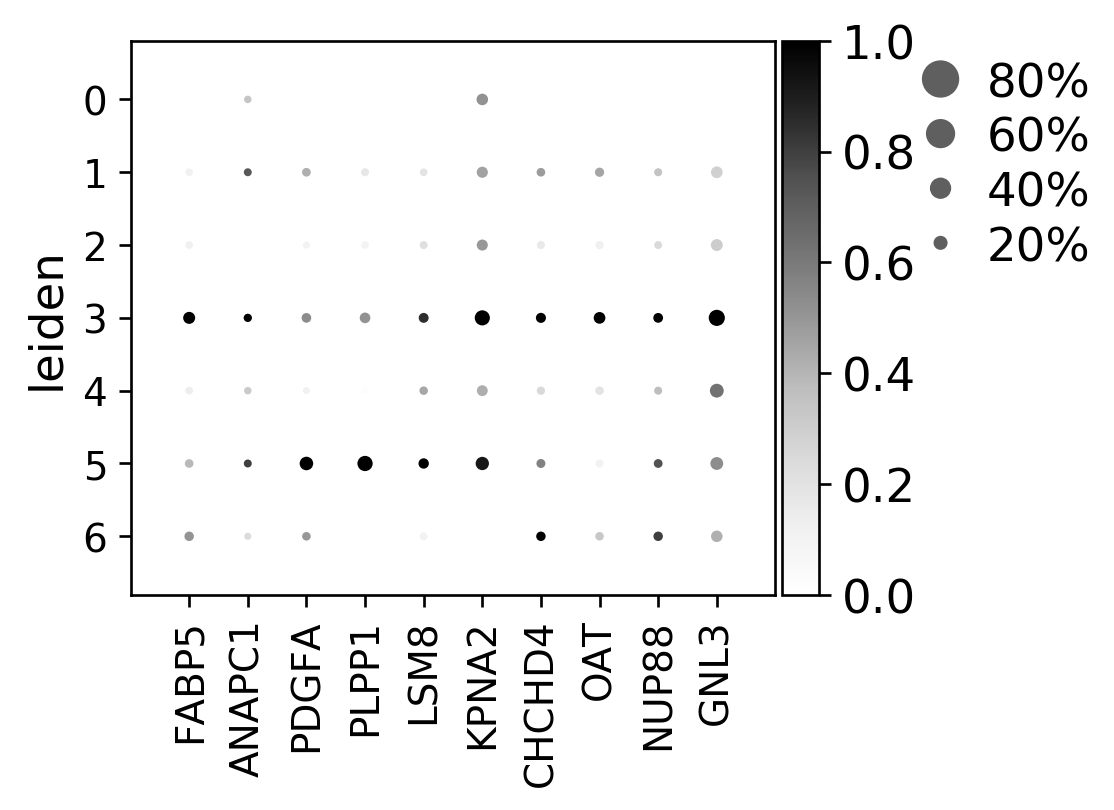

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[3.5, 0, 0.2, 0.5, 0.25])

In [91]:
# Generate Dot Plots
mouse_hox=['FABP5','ANAPC1','PDGFA','PLPP1','LSM8', 'KPNA2', 'CHCHD4','OAT','NUP88','GNL3',]
# Generate Dot Plots

sc.pl.dotplot(mmES_sub_sub2, mouse_hox, groupby='leiden',  log=True, num_categories=6, 
              expression_cutoff=0.0, mean_only_expressed=None, color_map='Greys', dot_max=0.8, 
              dot_min=None, figsize=None, dendrogram=None, gene_symbols=None, var_group_positions=None, 
              standard_scale='var', smallest_dot=4, var_group_labels=None, var_group_rotation=None, 
              layer=None, show=None, save='chicken_NMP_dotplot.png')

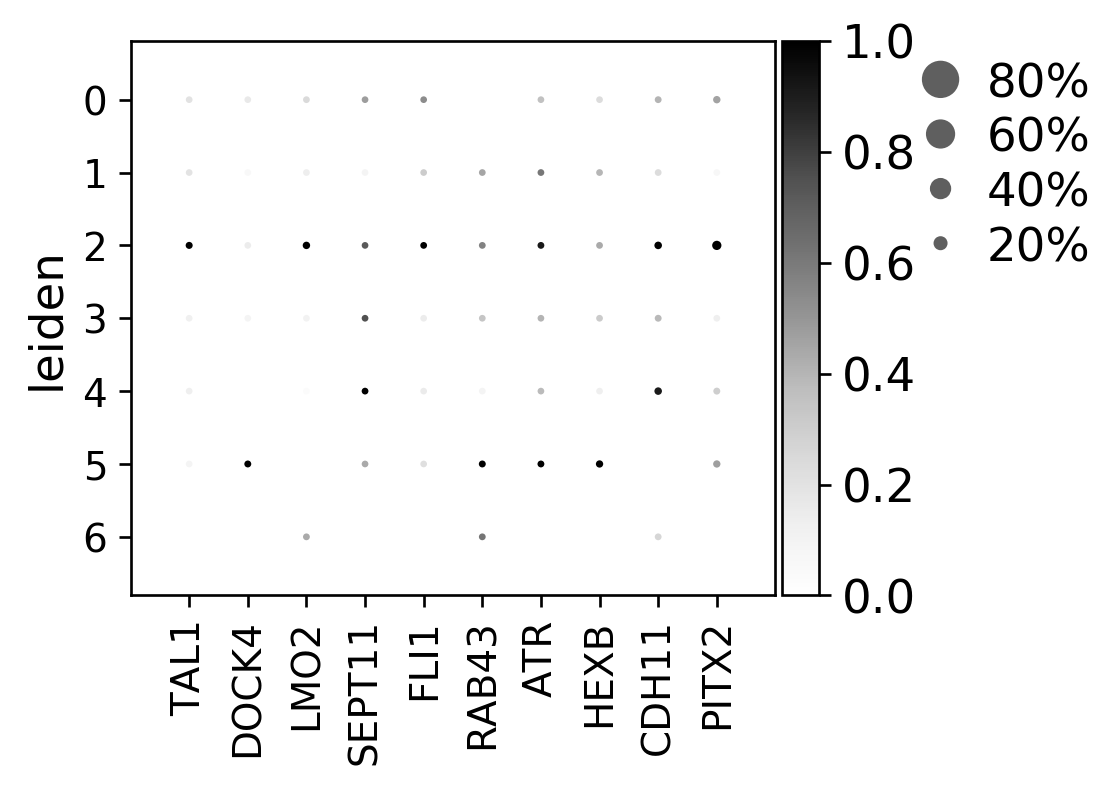

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[3.5, 0, 0.2, 0.5, 0.25])

In [92]:
# Generate Dot Plots
mouse_hox=['TAL1','DOCK4','LMO2','SEPT11','FLI1', 'RAB43', 'ATR','HEXB','CDH11','PITX2',]
# Generate Dot Plots

sc.pl.dotplot(mmES_sub_sub2, mouse_hox, groupby='leiden',  log=True, num_categories=6, 
              expression_cutoff=0.0, mean_only_expressed=None, color_map='Greys', dot_max=0.8, 
              dot_min=None, figsize=None, dendrogram=None, gene_symbols=None, var_group_positions=None, 
              standard_scale='var', smallest_dot=4, var_group_labels=None, var_group_rotation=None, 
              layer=None, show=None, save='chicken_NMP_dotplot.png')

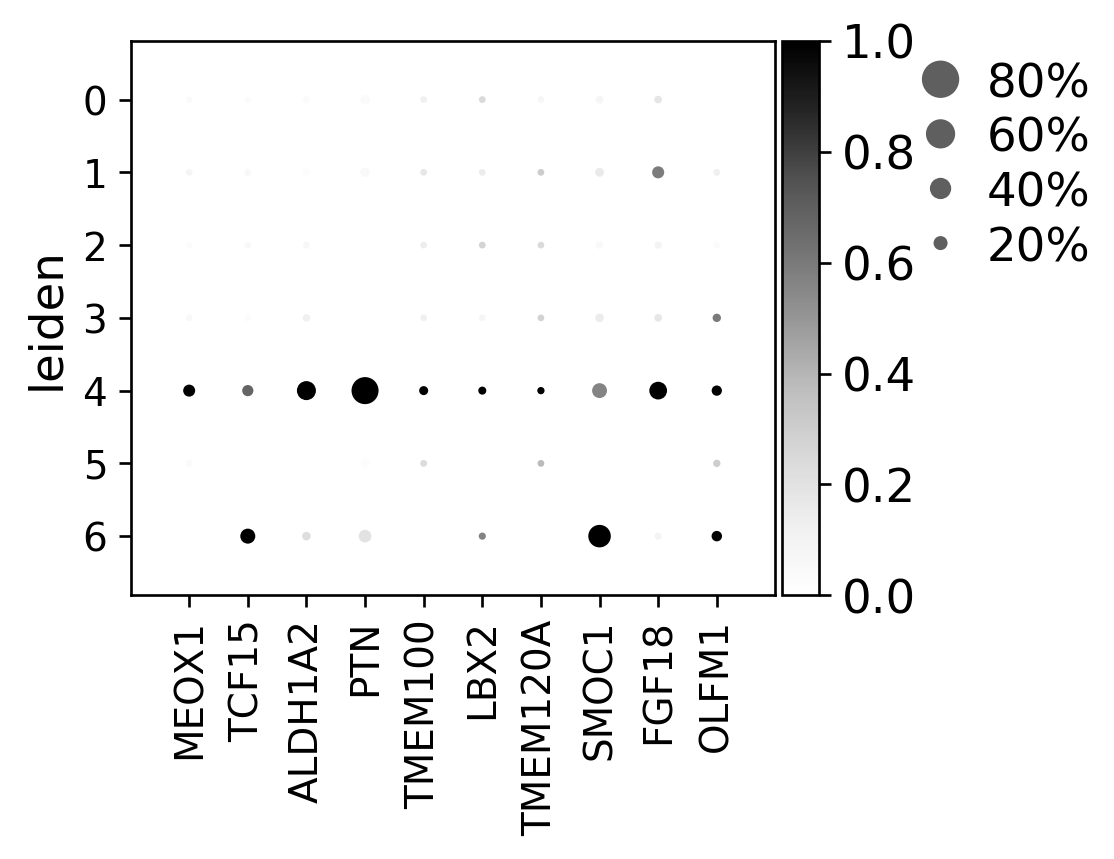

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[3.5, 0, 0.2, 0.5, 0.25])

In [93]:
# Generate Dot Plots
mouse_hox=['MEOX1','TCF15','ALDH1A2','PTN','TMEM100', 'LBX2', 'TMEM120A','SMOC1','FGF18','OLFM1',]
# Generate Dot Plots

sc.pl.dotplot(mmES_sub_sub2, mouse_hox, groupby='leiden',  log=True, num_categories=6, 
              expression_cutoff=0.0, mean_only_expressed=None, color_map='Greys', dot_max=0.8, 
              dot_min=None, figsize=None, dendrogram=None, gene_symbols=None, var_group_positions=None, 
              standard_scale='var', smallest_dot=4, var_group_labels=None, var_group_rotation=None, 
              layer=None, show=None, save='chicken_NMP_dotplot.png')

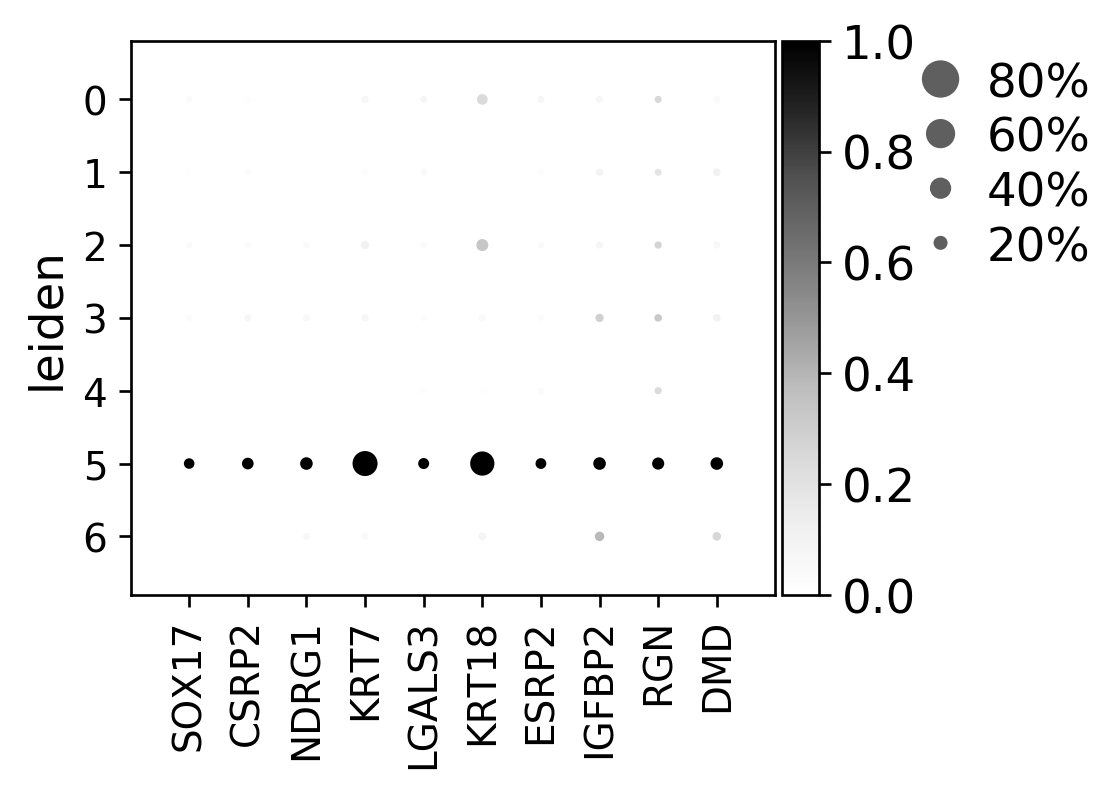

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[3.5, 0, 0.2, 0.5, 0.25])

In [94]:
# Generate Dot Plots
mouse_hox=['SOX17','CSRP2','NDRG1','KRT7','LGALS3', 'KRT18', 'ESRP2','IGFBP2','RGN','DMD',]
# Generate Dot Plots

sc.pl.dotplot(mmES_sub_sub2, mouse_hox, groupby='leiden',  log=True, num_categories=6, 
              expression_cutoff=0.0, mean_only_expressed=None, color_map='Greys', dot_max=0.8, 
              dot_min=None, figsize=None, dendrogram=None, gene_symbols=None, var_group_positions=None, 
              standard_scale='var', smallest_dot=4, var_group_labels=None, var_group_rotation=None, 
              layer=None, show=None, save='chicken_NMP_dotplot.png')

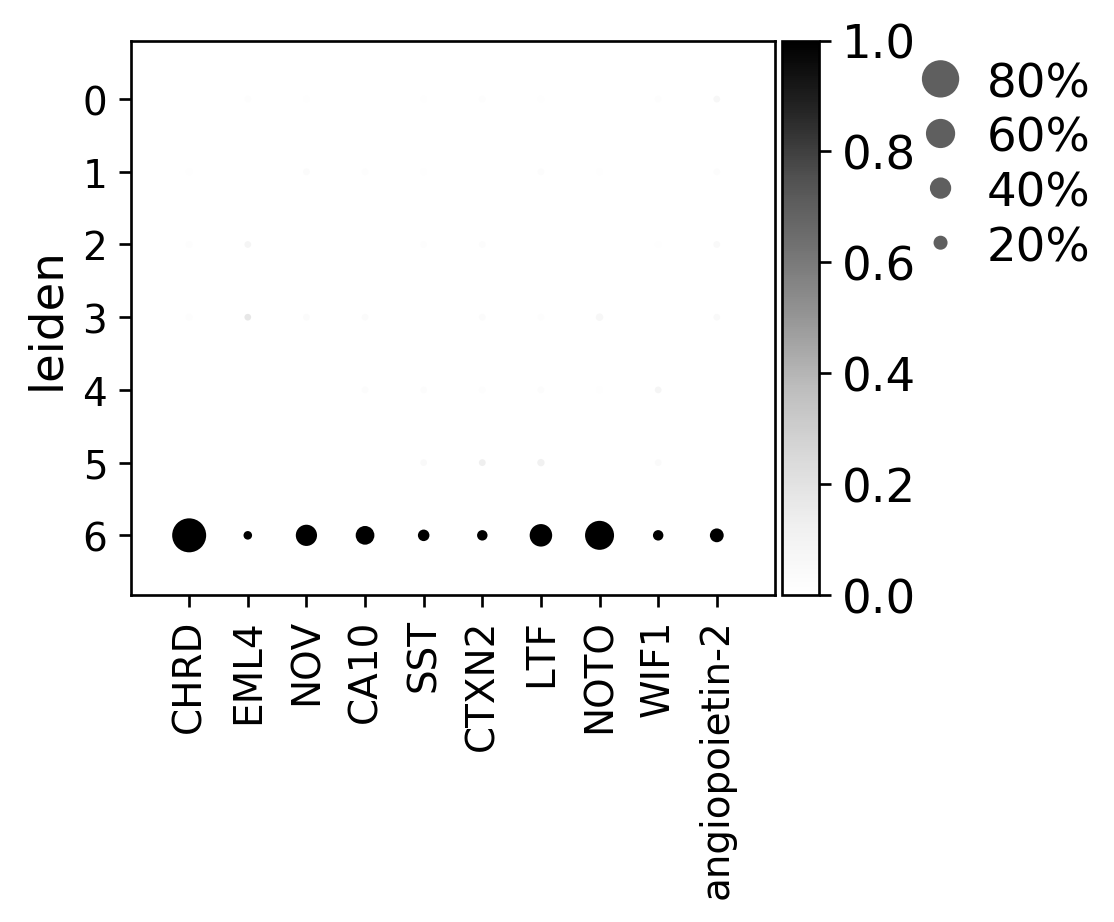

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[3.5, 0, 0.2, 0.5, 0.25])

In [95]:
# Generate Dot Plots
mouse_hox=['CHRD','EML4','NOV','CA10','SST', 'CTXN2', 'LTF','NOTO','WIF1','angiopoietin-2',]
# Generate Dot Plots

sc.pl.dotplot(mmES_sub_sub2, mouse_hox, groupby='leiden',  log=True, num_categories=6, 
              expression_cutoff=0.0, mean_only_expressed=None, color_map='Greys', dot_max=0.8, 
              dot_min=None, figsize=None, dendrogram=None, gene_symbols=None, var_group_positions=None, 
              standard_scale='var', smallest_dot=4, var_group_labels=None, var_group_rotation=None, 
              layer=None, show=None, save='chicken_NMP_dotplot.png')

running PAGA
    finished (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


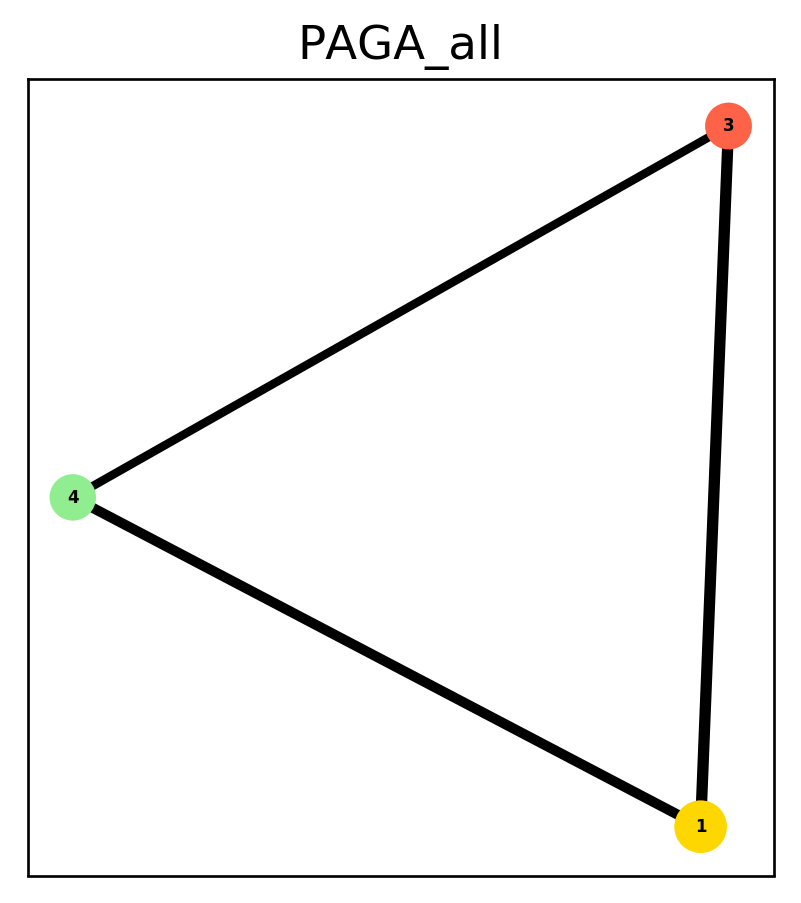

In [98]:
mmES_sub_sub2 = mmES[~mmES.obs['leiden'].isin(['0','2','5','6','7','8','9','10']),:]
sc.tl.paga(mmES_sub_sub2, groups='leiden')#
sc.pl.paga(mmES_sub_sub2, threshold=0.3, edge_width_scale=1, fontsize=5, show=False, title='PAGA_all')

### Save AnnData DataSet to File

In [99]:
mmES.obs.to_csv('datachicken_6s_full.csv')
mmES.write('datachicken_6s.h5ad')

### Load AnnData DataSet from File

In [100]:
mmES = sc.read('datachicken_6s.h5ad')
print(mmES)

AnnData object with n_obs × n_vars = 1635 × 10443 
    obs: 'batch', 'cell_names', 'library_id', 'n_counts', 'unique_cell_id', 'time_id', 'sample_id', 'n_genes', 'n_counts_pre_norm', 'S_score', 'G2M_score', 'phase', 'leiden'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'leiden', 'leiden_colors', 'library_id_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
